# Etap 2

## Spis treści:
* [Opis](#opis)

* [Podsumowanie](#podsumowanie)

* [Zależności i definicje](#zf)

* [Czarne tło](#black)
    * [Czarne tło - Xception](#black-xception)
    * [Czarne tło - VGG16](#black-vgg16)
    * [Czarne tło - ResNet50](#black-resnet50)
    
* [Białe tło](#white)
    * [Białe tło - Xception](#white-xception)
    * [Białe tło - VGG16](#white-vgg16)
    * [Białe tło - ResNet50](#white-resnet50)

* [Krawędzie](#edge)
    * [Krawędzie - Xception](#edge-xception)
    * [Krawędzie - VGG16](#edge-vgg16)
    * [Krawędzie - ResNet50](#edge-resnet50)

* [Porównanie architektur](#comp-a)
    * [Porównanie architektur z użyciem czarnego tła](#comp-black)
    * [Porównanie architektur z użyciem białego tła](#comp-white)
    * [Porównanie architektur z użyciem krawędzi](#comp-edge)

* [Porównanie zbiorów uczącyc](#comp-z)
    * [Porównanie zbiorów - Xception](#comp-xception)
    * [Porównanie zbiorów - VGG16](#comp-vgg16)
    * [Porównanie zbiorów - ResNet50](#comp-resnet50)

# Opis <a class="anchor" id="opis"></a>

W tym dokumencie przedstawiono dokładniejsze porównanie sieci neuronowych z wykorzystaniem gotowych architektur:
- Xception, 
- VGG16, 
- ResNet50

Zbadany został również proces uczenia sieci neuronowych dla różnego typu zbiorów danych:
- obiekty na czarnym tle
- obiekty na białym tle
- wyłącznie białe krawędzie obiektów na czarnym tle

Obrazy zostały wygenerowane w rozdzielczość 500x500. Motywacją do tej zmiany było wygodniejsze porównywanie źle zaklasyfikowanych obrazów.

W każdym teście dokonano podziału zbioru danych za pomocą metody StratifiedKFold z podziałem na 10 podzbiorów. Do modeli dodano dodatkową warstwę Dropout(0.2). Ograniczyło to częste występowanie przeuczenia.  
Dla każdej z architektur zainicjowano wagi uzyskane z uczenia na zbiorze ImageNet oraz zablokowano ich edycję. Przez zastosowanie obrazów o wyższej rozdzielczości nie udało się przeprowadzić testów z odblokowaną możliwością edycji zaimportowanych wag (niewystarczająca ilość pamięci GPU).

Testy zostały uruchomione z identycznymi ustawieniami. Jedynym wyjątkiem było zmniejszenie parametru learning_rate z 0.005 do 0.001 dla architektury ResNet50. Przy wyższych wartościach modele z tą architekturą nie poprawiały swoich wyników podczas uczenia (wyniki z tej sytuacji dostępne są w folderach *results/black_background_data_resnet50, results/white_background_data_resnet50, results/edge_data_resnet50*).

# Podsumowanie <a class="anchor" id="podsumowanie"></a>
Najlepsze wyniki uzyskano za pomocą architektury Xception. Architektury VGG16 oraz ResNet50 uzyskiwały słabsze, zbliżone do siebie rezultaty.

Typ zbioru danych inaczej wpływał na każdą z architektur:
- Xception, Kolor tła nie wpływał na zdolności rozpoznawania kształtów natomiat zastosowanie zbióru z krawędziami poprawiło jakość klasyfikacji o 4%. 
- VGG16, Lepsze wyniki na zbiorach z czarnym i białym tłem
- ResNet50, Lepsze wyniki na białym tle

ResNet50 wymaga więcej wysiłku przy doborze hiperparametrów. Na wykresie ukazującym przebieg uczenia można zauważyć dużą rozbieżność w trafności w zależności od dostarczonej części zbioru uczącego.

Xception podczas korzystania obrazów z krawędziami uzyskała 100% trafności na zbiorze testowym w szóstym podzbiorze kroswalidacji.

Istnieje możliwość poprawienia klasyfikacji lub przyspieszenia jej funkcjonowania poprzez dobór odpowiednich hiperparametrów i rozdzielczości danych wejściowych.

# Zależności i definicje <a class="anchor" id="zf"></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
import pandas as pd
import math

black_train_results = []
white_train_results = []
edge_train_results = []

black_test_results = []
white_test_results = []
edge_test_results = []

#plt.rcParams['figure.dpi'] = 150

def show_confusion_matrix(data_path):
    matrices = []
    for i in range(1, 11):
        path = f'{data_path}/{i}_fold_confusion_matrix.png'
        img = Image.open(path)
        matrices.append(np.asarray(img))


    fig = plt.figure(figsize=(20., 30.))
    grid = ImageGrid(fig, 111, 
                     nrows_ncols=(5, 2),
                     axes_pad=0.1,
                     )

    for ax, im in zip(grid, matrices):
        ax.imshow(im)
        
    plt.show()
    
def show_training_history(data_path):
    training_history = np.loadtxt(data_path + '/training_history.csv', delimiter=',')
    x = np.arange(1,11)

    for i in range(10):
        plt.plot(x, training_history[i])

    plt.grid()
    plt.title('Model accuracy during training')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.show()

def show_misclassified(data_path):
    for i in range(1, 11):
        path = f'{data_path}/{i}_fold_misclassified.csv'
        df = pd.read_csv (path)
        print(f'Fold: {i}')
        display(df)
        
def compare_train_and_test_acc(data_path, train_results, test_results):
    train_acc = np.loadtxt(data_path + '/training_history.csv', delimiter=',')
    test_acc = np.loadtxt(data_path + '/test_acc.csv', delimiter=',')
    
    best_train_acc_from_folds = np.amax(train_acc, axis=1)
    train_mean = np.mean(best_train_acc_from_folds)
    
    train_results.append(train_mean)
    test_mean = np.mean(test_acc)
    test_results.append(test_mean)
    
    titles = []
    for i in range(10):
        titles.append(f'Fold: {i+1}')
    
    means = ['Mean', train_mean, test_mean]
    df = pd.DataFrame([titles, best_train_acc_from_folds, test_acc], index =['', 'Training ACC', 'Test Acc'])
    df['10'] = means
    
    display(df)
    
def compare_architecture(train_acc, test_acc):
    labels = ['Xception','VGG16','ResNet50']
    x = np.arange(len(labels))
    width = 0.4

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, train_acc, width, label='Train data')
    rects2 = ax.bar(x + width/2, test_acc, width, label='Test data')

    ax.set_ylabel('Accuracy')
    ax.set_title('Accuracy by architecture')
    plt.xticks(range(len(labels)), labels)
    ax.legend()

    ax.bar_label(rects1, padding=1)
    ax.bar_label(rects2, padding=1)

    fig.tight_layout()
    fig.set_size_inches(15, 10)

    plt.show()
    
def compare_dataset(train_acc, test_acc):
    labels = ['Black','White','Edge']
    x = np.arange(len(labels))
    width = 0.4

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, train_acc, width, label='Train data')
    rects2 = ax.bar(x + width/2, test_acc, width, label='Test data')

    ax.set_ylabel('Accuracy')
    ax.set_title('Accuracy by dataset')
    plt.xticks(range(len(labels)), labels)
    ax.legend()

    ax.bar_label(rects1, padding=1)
    ax.bar_label(rects2, padding=1)

    fig.tight_layout()
    fig.set_size_inches(15, 10)

    plt.show()

# Czarne tło <a class="anchor" id="black"></a>

## Czarne tło - Xception <a class="anchor" id="black-xception"></a>

,0,1,2,3,4,5,6,7,8,9,10
,Fold: 1,Fold: 2,Fold: 3,Fold: 4,Fold: 5,Fold: 6,Fold: 7,Fold: 8,Fold: 9,Fold: 10,Mean
Training ACC,0.920322,0.929825,0.949561,0.957602,0.88231,0.940789,0.904971,0.945906,0.930556,0.934211,0.929605
Test Acc,0.927632,0.927632,0.934211,0.953947,0.868421,0.953947,0.921053,0.875,0.973684,0.940789,0.927632


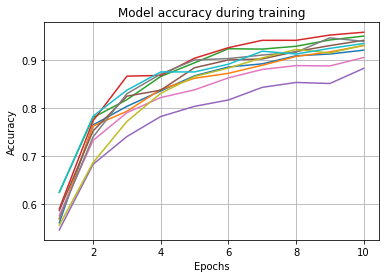

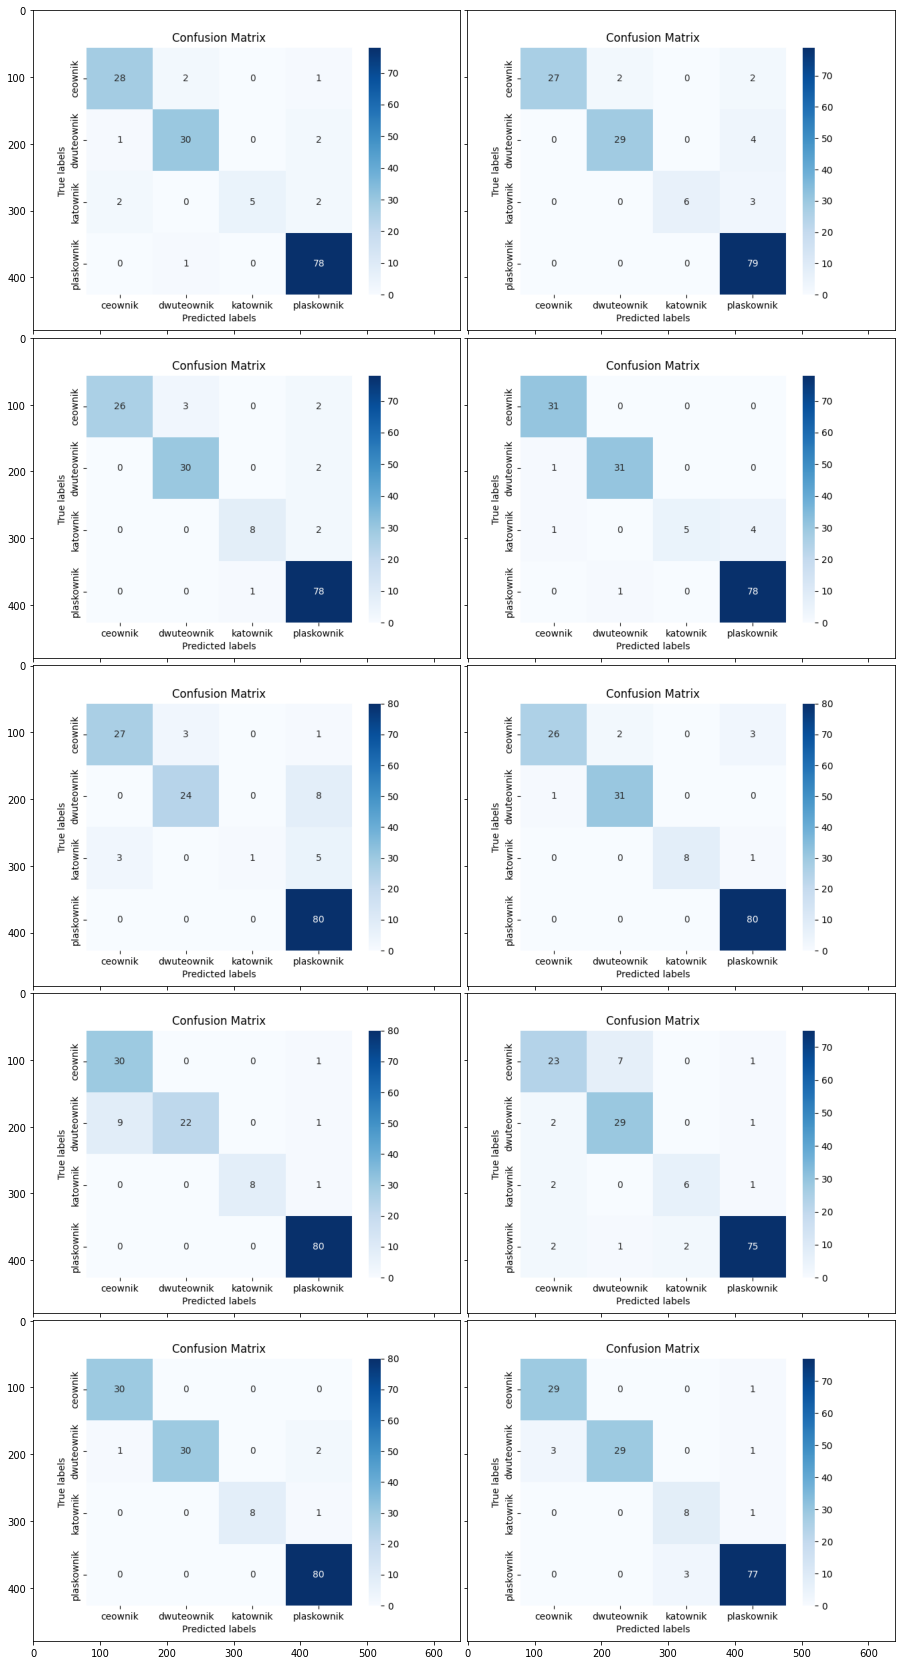

In [2]:
data = 'results/black_background_data_xception'
compare_train_and_test_acc(data, black_train_results, black_test_results)
show_training_history(data)
show_confusion_matrix(data)

In [3]:
show_misclassified(data)

Fold: 1


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00067-view02.png,ceownik,dwuteownik,0.275276,0.692936,0.000251,0.031537
1,ceownik_00068-view03.png,ceownik,plaskownik,0.272287,0.005945,0.002176,0.719591
2,ceownik_00072-view02.png,ceownik,dwuteownik,0.089947,0.902360,0.000011,0.007682
3,dwuteownik_00031-view04.png,dwuteownik,plaskownik,0.038068,0.022642,0.004302,0.934988
4,dwuteownik_00042-view04.png,dwuteownik,plaskownik,0.021061,0.036558,0.002082,0.940299
5,dwuteownik_00085-view04.png,dwuteownik,ceownik,0.534566,0.449432,0.000054,0.015949
6,katownik_00010-view02.png,katownik,plaskownik,0.059631,0.045721,0.006390,0.888258
7,katownik_00012-view04.png,katownik,ceownik,0.388256,0.006823,0.318148,0.286774
8,katownik_00015-view01.png,katownik,ceownik,0.450071,0.004085,0.259347,0.286496
9,katownik_00015-view02.png,katownik,plaskownik,0.250073,0.110786,0.047169,0.591971


Fold: 2


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00053-view01.png,ceownik,plaskownik,0.022093,0.001924,0.000495,0.975488
1,ceownik_00053-view03.png,ceownik,dwuteownik,0.315438,0.416121,0.003974,0.264467
2,ceownik_00054-view02.png,ceownik,plaskownik,0.103244,0.002444,0.001066,0.893245
3,ceownik_00058-view02.png,ceownik,dwuteownik,0.467275,0.470146,0.010037,0.052542
4,dwuteownik_00027-view01.png,dwuteownik,plaskownik,0.127381,0.127852,0.192004,0.552763
5,dwuteownik_00033-view01.png,dwuteownik,plaskownik,0.093555,0.083906,0.001503,0.821036
6,dwuteownik_00043-view01.png,dwuteownik,plaskownik,0.026266,0.075007,0.001607,0.897120
7,dwuteownik_00046-view02.png,dwuteownik,plaskownik,0.051020,0.056000,0.000252,0.892728
8,katownik_00010-view01.png,katownik,plaskownik,0.015857,0.001278,0.121121,0.861744
9,katownik_00013-view02.png,katownik,plaskownik,0.006374,0.000981,0.211379,0.781267


Fold: 3


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00017-view01.png,ceownik,dwuteownik,0.186832,0.807511,0.001649,0.004008
1,ceownik_00048-view04.png,ceownik,dwuteownik,0.197960,0.781663,0.008492,0.011886
2,ceownik_00055-view03.png,ceownik,plaskownik,0.344069,0.120171,0.024670,0.511089
3,ceownik_00063-view01.png,ceownik,plaskownik,0.131973,0.016376,0.007907,0.843744
4,ceownik_00068-view04.png,ceownik,dwuteownik,0.268686,0.561660,0.116486,0.053169
5,dwuteownik_00024-view01.png,dwuteownik,plaskownik,0.008914,0.025478,0.003639,0.961969
6,dwuteownik_00042-view03.png,dwuteownik,plaskownik,0.004469,0.012300,0.003261,0.979970
7,katownik_00010-view03.png,katownik,plaskownik,0.000179,0.000028,0.006843,0.992950
8,katownik_00012-view03.png,katownik,plaskownik,0.009602,0.013245,0.266344,0.710809
9,plaskownik_00171-view01.png,plaskownik,katownik,0.009061,0.000901,0.905017,0.085020


Fold: 4


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,dwuteownik_00020-view03.png,dwuteownik,ceownik,0.442590,0.303596,0.245671,0.008144
1,katownik_00011-view02.png,katownik,plaskownik,0.000233,0.000099,0.000504,0.999163
2,katownik_00011-view03.png,katownik,plaskownik,0.340180,0.004803,0.030194,0.624823
3,katownik_00015-view04.png,katownik,ceownik,0.534355,0.009703,0.436855,0.019088
4,katownik_00023-view01.png,katownik,plaskownik,0.005762,0.073930,0.173205,0.747103
5,katownik_00023-view03.png,katownik,plaskownik,0.004898,0.001793,0.018193,0.975116
6,plaskownik_00165-view04.png,plaskownik,dwuteownik,0.021545,0.803953,0.014193,0.160309


Fold: 5


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00018-view01.png,ceownik,dwuteownik,0.064015,0.803875,0.009064,0.123045
1,ceownik_00018-view04.png,ceownik,dwuteownik,0.410185,0.465179,0.005553,0.119083
2,ceownik_00063-view03.png,ceownik,plaskownik,0.163759,0.006209,0.000248,0.829783
3,ceownik_00072-view03.png,ceownik,dwuteownik,0.112337,0.674652,0.012440,0.200572
4,dwuteownik_00015-view03.png,dwuteownik,plaskownik,0.070411,0.083252,0.001689,0.844648
5,dwuteownik_00016-view03.png,dwuteownik,plaskownik,0.070145,0.082524,0.001666,0.845664
6,dwuteownik_00017-view03.png,dwuteownik,plaskownik,0.069948,0.085263,0.001643,0.843145
7,dwuteownik_00024-view03.png,dwuteownik,plaskownik,0.026947,0.113245,0.000457,0.859351
8,dwuteownik_00042-view01.png,dwuteownik,plaskownik,0.028428,0.138033,0.000502,0.833036
9,dwuteownik_00046-view01.png,dwuteownik,plaskownik,0.023098,0.050745,0.000052,0.926105


Fold: 6


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00003-view04.png,ceownik,dwuteownik,0.348014,0.637208,0.000629,0.014149
1,ceownik_00005-view02.png,ceownik,plaskownik,0.472304,0.006356,0.027274,0.494065
2,ceownik_00006-view03.png,ceownik,plaskownik,0.461344,0.007990,0.024482,0.506184
3,ceownik_00017-view04.png,ceownik,dwuteownik,0.350433,0.632642,0.000392,0.016533
4,ceownik_00075-view01.png,ceownik,plaskownik,0.021736,0.009447,0.000228,0.968589
5,dwuteownik_00046-view03.png,dwuteownik,ceownik,0.737462,0.231288,0.002586,0.028665
6,katownik_00015-view03.png,katownik,plaskownik,0.054480,0.015616,0.023545,0.906359


Fold: 7


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00055-view04.png,ceownik,plaskownik,0.263347,0.053582,0.006343,0.676728
1,dwuteownik_00007-view04.png,dwuteownik,ceownik,0.598106,0.386485,0.001041,0.014368
2,dwuteownik_00008-view04.png,dwuteownik,ceownik,0.660506,0.324277,0.001170,0.014047
3,dwuteownik_00011-view01.png,dwuteownik,ceownik,0.511305,0.461291,0.001567,0.025837
4,dwuteownik_00021-view01.png,dwuteownik,ceownik,0.651938,0.236412,0.006184,0.105465
5,dwuteownik_00027-view02.png,dwuteownik,plaskownik,0.093533,0.024245,0.136233,0.745989
6,dwuteownik_00072-view01.png,dwuteownik,ceownik,0.657543,0.331578,0.000894,0.009985
7,dwuteownik_00073-view01.png,dwuteownik,ceownik,0.590651,0.389804,0.002067,0.017479
8,dwuteownik_00077-view01.png,dwuteownik,ceownik,0.413253,0.355860,0.004390,0.226497
9,dwuteownik_00080-view01.png,dwuteownik,ceownik,0.561103,0.431624,0.000393,0.006880


Fold: 8


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00004-view01.png,ceownik,dwuteownik,0.437377,0.556120,0.000026,0.006477
1,ceownik_00005-view03.png,ceownik,dwuteownik,0.301951,0.571657,0.006390,0.120003
2,ceownik_00035-view01.png,ceownik,dwuteownik,0.150870,0.796333,0.000012,0.052786
3,ceownik_00050-view02.png,ceownik,dwuteownik,0.089292,0.897956,0.000053,0.012699
4,ceownik_00055-view02.png,ceownik,dwuteownik,0.199459,0.775604,0.000066,0.024871
5,ceownik_00063-view02.png,ceownik,plaskownik,0.018162,0.011377,0.000301,0.970160
6,ceownik_00067-view01.png,ceownik,dwuteownik,0.005690,0.992919,0.000003,0.001388
7,ceownik_00077-view03.png,ceownik,dwuteownik,0.126896,0.868300,0.000066,0.004737
8,dwuteownik_00033-view02.png,dwuteownik,plaskownik,0.002839,0.295395,0.000002,0.701764
9,dwuteownik_00083-view01.png,dwuteownik,ceownik,0.971896,0.027105,0.000015,0.000983


Fold: 9


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,dwuteownik_00021-view02.png,dwuteownik,ceownik,0.498645,0.267052,0.005979,0.228324
1,dwuteownik_00024-view02.png,dwuteownik,plaskownik,0.021340,0.079747,0.016358,0.882555
2,dwuteownik_00082-view03.png,dwuteownik,plaskownik,0.007520,0.043558,0.030133,0.918789
3,katownik_00023-view02.png,katownik,plaskownik,0.001982,0.000004,0.001997,0.996016


Fold: 10


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00052-view02.png,ceownik,plaskownik,0.468755,0.041044,0.000732,0.489469
1,dwuteownik_00023-view03.png,dwuteownik,ceownik,0.438314,0.426424,0.025168,0.110094
2,dwuteownik_00027-view03.png,dwuteownik,plaskownik,0.032579,0.036598,0.247938,0.682884
3,dwuteownik_00027-view04.png,dwuteownik,ceownik,0.372400,0.197279,0.123348,0.306972
4,dwuteownik_00083-view04.png,dwuteownik,ceownik,0.546327,0.426723,0.000606,0.026345
5,katownik_00005-view01.png,katownik,plaskownik,0.001323,0.003294,0.380453,0.614929
6,plaskownik_00013-view04.png,plaskownik,katownik,0.011772,0.015356,0.646327,0.326545
7,plaskownik_00164-view02.png,plaskownik,katownik,0.004076,0.001829,0.498165,0.495930
8,plaskownik_00181-view01.png,plaskownik,katownik,0.000754,0.000620,0.865754,0.132871


## Czarne tło - VGG16 <a class="anchor" id="black-vgg16"></a>

,0,1,2,3,4,5,6,7,8,9,10
,Fold: 1,Fold: 2,Fold: 3,Fold: 4,Fold: 5,Fold: 6,Fold: 7,Fold: 8,Fold: 9,Fold: 10,Mean
Training ACC,0.866959,0.819444,0.755117,0.858918,0.898392,0.869152,0.833333,0.848684,0.767544,0.831871,0.834942
Test Acc,0.875,0.875,0.75,0.888158,0.934211,0.894737,0.842105,0.835526,0.769737,0.888158,0.855263


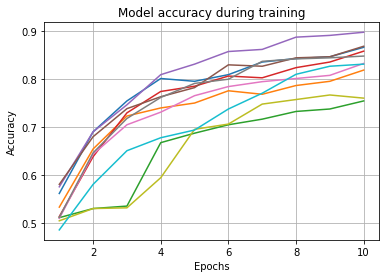

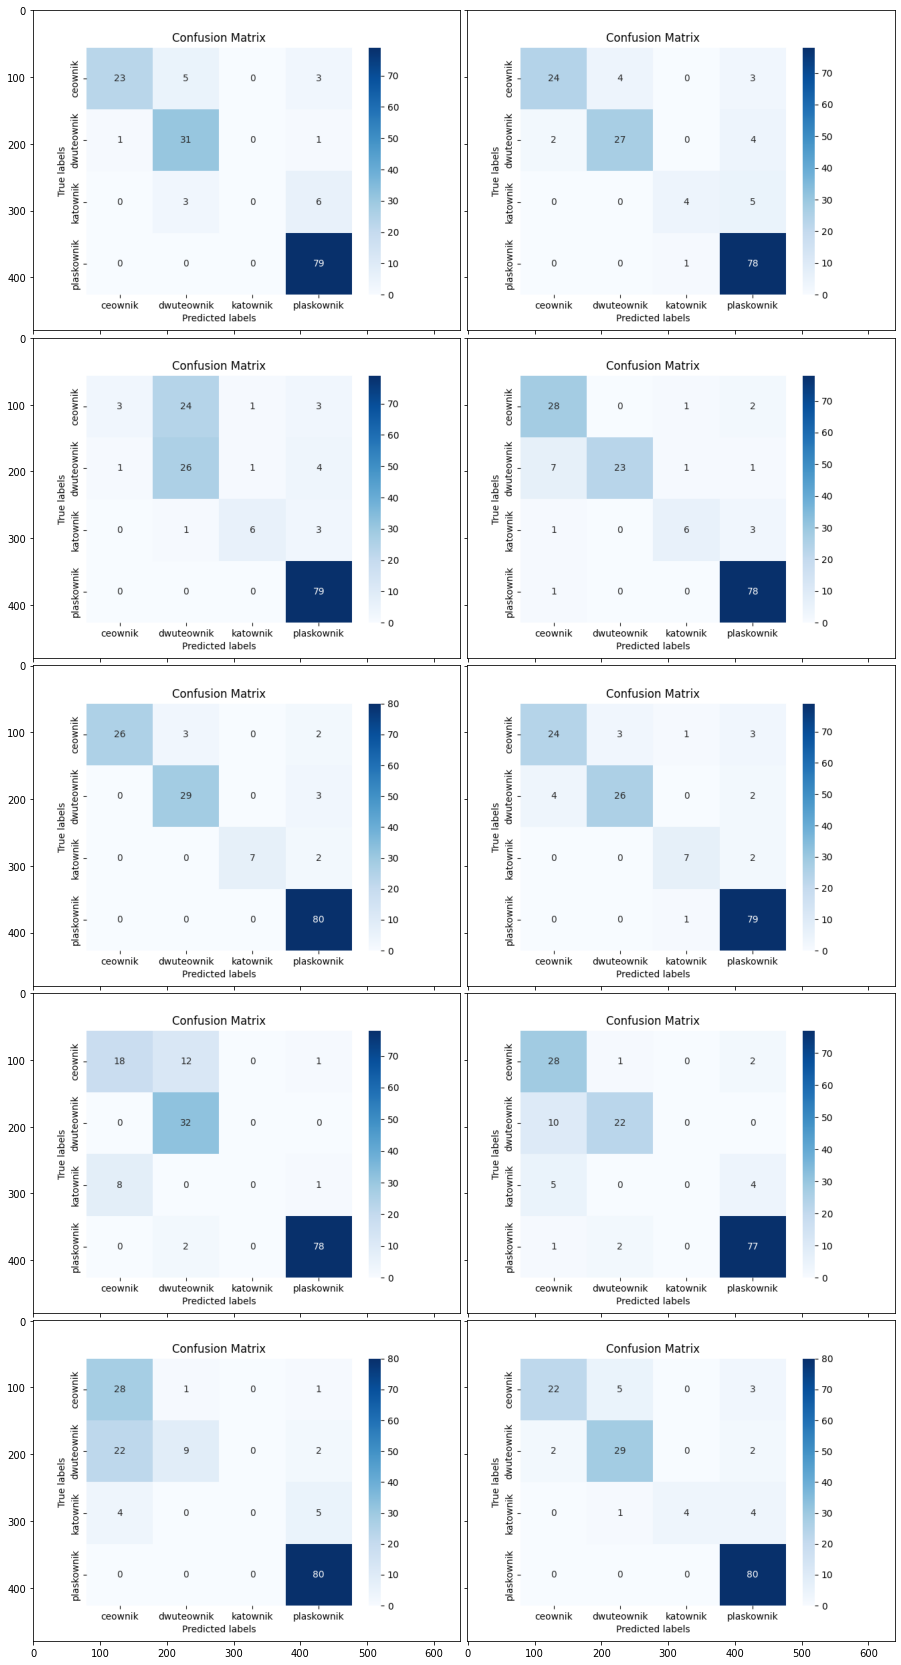

In [4]:
data = 'results/black_background_data_vgg16'
compare_train_and_test_acc(data, black_train_results, black_test_results)
show_training_history(data)
show_confusion_matrix(data)

In [5]:
show_misclassified(data)

Fold: 1


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00005-view04.png,ceownik,dwuteownik,0.278027,0.471888,0.083253,0.166832
1,ceownik_00006-view02.png,ceownik,plaskownik,0.253400,0.111863,0.178524,0.456214
2,ceownik_00015-view02.png,ceownik,dwuteownik,0.309170,0.588137,0.012586,0.090108
3,ceownik_00054-view04.png,ceownik,plaskownik,0.048879,0.001109,0.003842,0.946171
4,ceownik_00058-view03.png,ceownik,dwuteownik,0.268812,0.387248,0.141402,0.202538
5,ceownik_00063-view04.png,ceownik,dwuteownik,0.112029,0.781294,0.000384,0.106293
6,ceownik_00068-view03.png,ceownik,plaskownik,0.017881,0.003599,0.024036,0.954484
7,ceownik_00072-view02.png,ceownik,dwuteownik,0.157993,0.833834,0.000106,0.008067
8,dwuteownik_00042-view02.png,dwuteownik,ceownik,0.453460,0.273085,0.020766,0.252689
9,dwuteownik_00042-view04.png,dwuteownik,plaskownik,0.023250,0.011714,0.122590,0.842447


Fold: 2


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00021-view03.png,ceownik,dwuteownik,0.276787,0.720615,0.001128,0.001470
1,ceownik_00038-view01.png,ceownik,dwuteownik,0.244742,0.754327,0.000395,0.000537
2,ceownik_00053-view01.png,ceownik,plaskownik,0.266171,0.006600,0.001145,0.726083
3,ceownik_00053-view03.png,ceownik,plaskownik,0.385600,0.004098,0.000278,0.610025
4,ceownik_00054-view02.png,ceownik,plaskownik,0.266293,0.014235,0.000814,0.718658
5,ceownik_00069-view03.png,ceownik,dwuteownik,0.276380,0.721055,0.001113,0.001452
6,ceownik_00073-view04.png,ceownik,dwuteownik,0.229510,0.769935,0.000233,0.000323
7,dwuteownik_00027-view01.png,dwuteownik,plaskownik,0.008760,0.004090,0.061256,0.925893
8,dwuteownik_00033-view01.png,dwuteownik,plaskownik,0.001158,0.005841,0.000009,0.992992
9,dwuteownik_00043-view01.png,dwuteownik,plaskownik,0.154170,0.026571,0.000014,0.819245


Fold: 3


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00001-view01.png,ceownik,dwuteownik,0.279022,0.287781,0.203115,0.230081
1,ceownik_00007-view04.png,ceownik,dwuteownik,0.279022,0.287781,0.203115,0.230081
2,ceownik_00008-view02.png,ceownik,dwuteownik,0.279022,0.287781,0.203115,0.230081
3,ceownik_00014-view03.png,ceownik,dwuteownik,0.279022,0.287781,0.203115,0.230081
4,ceownik_00017-view01.png,ceownik,dwuteownik,0.279022,0.287781,0.203115,0.230081
5,ceownik_00018-view02.png,ceownik,dwuteownik,0.279022,0.287781,0.203115,0.230081
6,ceownik_00019-view03.png,ceownik,dwuteownik,0.279022,0.287781,0.203115,0.230081
7,ceownik_00023-view04.png,ceownik,dwuteownik,0.279022,0.287781,0.203115,0.230081
8,ceownik_00026-view04.png,ceownik,dwuteownik,0.279022,0.287781,0.203115,0.230081
9,ceownik_00029-view03.png,ceownik,dwuteownik,0.279022,0.287781,0.203115,0.230081


Fold: 4


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00005-view01.png,ceownik,katownik,0.117890,0.129599,0.426611,0.325901
1,ceownik_00049-view03.png,ceownik,plaskownik,0.230664,0.054591,0.035719,0.679026
2,ceownik_00054-view01.png,ceownik,plaskownik,0.104788,0.001417,0.000089,0.893706
3,dwuteownik_00001-view02.png,dwuteownik,ceownik,0.917211,0.072651,0.000003,0.010135
4,dwuteownik_00008-view03.png,dwuteownik,ceownik,0.709902,0.272219,0.000025,0.017854
5,dwuteownik_00009-view01.png,dwuteownik,ceownik,0.712261,0.274745,0.000010,0.012983
6,dwuteownik_00010-view01.png,dwuteownik,ceownik,0.740266,0.246098,0.000011,0.013626
7,dwuteownik_00024-view04.png,dwuteownik,ceownik,0.584280,0.156616,0.006279,0.252824
8,dwuteownik_00031-view03.png,dwuteownik,katownik,0.084424,0.125555,0.450647,0.339374
9,dwuteownik_00043-view02.png,dwuteownik,plaskownik,0.185606,0.074744,0.005856,0.733794


Fold: 5


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00018-view01.png,ceownik,dwuteownik,0.235409,0.694422,0.001539,0.068630
1,ceownik_00018-view04.png,ceownik,dwuteownik,0.282987,0.505072,0.032465,0.179476
2,ceownik_00050-view04.png,ceownik,plaskownik,0.436428,0.120656,0.000491,0.442425
3,ceownik_00063-view03.png,ceownik,plaskownik,0.139957,0.021880,0.000021,0.838142
4,ceownik_00072-view03.png,ceownik,dwuteownik,0.272731,0.566710,0.015397,0.145162
5,dwuteownik_00024-view03.png,dwuteownik,plaskownik,0.249401,0.329919,0.061457,0.359222
6,dwuteownik_00042-view01.png,dwuteownik,plaskownik,0.238068,0.328577,0.046935,0.386420
7,dwuteownik_00046-view01.png,dwuteownik,plaskownik,0.000591,0.004772,0.000105,0.994531
8,katownik_00019-view03.png,katownik,plaskownik,0.002502,0.000689,0.245556,0.751253
9,katownik_00023-view04.png,katownik,plaskownik,0.006946,0.002041,0.021178,0.969835


Fold: 6


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00002-view02.png,ceownik,dwuteownik,0.304719,0.498255,0.129661,0.067365
1,ceownik_00003-view04.png,ceownik,dwuteownik,0.273788,0.655578,0.059397,0.011237
2,ceownik_00005-view02.png,ceownik,plaskownik,0.239565,0.252245,0.245640,0.262550
3,ceownik_00006-view03.png,ceownik,plaskownik,0.239565,0.252245,0.245640,0.262550
4,ceownik_00006-view04.png,ceownik,katownik,0.078696,0.185300,0.384112,0.351892
5,ceownik_00017-view04.png,ceownik,dwuteownik,0.240722,0.730230,0.015653,0.013395
6,ceownik_00075-view01.png,ceownik,plaskownik,0.242975,0.061506,0.094501,0.601018
7,dwuteownik_00001-view03.png,dwuteownik,ceownik,0.597991,0.400966,0.000922,0.000121
8,dwuteownik_00023-view02.png,dwuteownik,ceownik,0.354935,0.347632,0.136781,0.160653
9,dwuteownik_00030-view01.png,dwuteownik,ceownik,0.564968,0.417357,0.006647,0.011028


Fold: 7


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00002-view03.png,ceownik,dwuteownik,0.271922,0.362984,0.144262,0.220832
1,ceownik_00003-view03.png,ceownik,dwuteownik,0.240317,0.536544,0.102843,0.120296
2,ceownik_00013-view01.png,ceownik,dwuteownik,0.287610,0.317530,0.193726,0.201134
3,ceownik_00019-view01.png,ceownik,dwuteownik,0.262930,0.456431,0.132319,0.148320
4,ceownik_00046-view03.png,ceownik,dwuteownik,0.288241,0.310742,0.197150,0.203867
5,ceownik_00055-view04.png,ceownik,plaskownik,0.099620,0.026777,0.070418,0.803185
6,ceownik_00057-view04.png,ceownik,dwuteownik,0.281204,0.367217,0.169994,0.181585
7,ceownik_00058-view01.png,ceownik,dwuteownik,0.221078,0.593514,0.084017,0.101391
8,ceownik_00058-view04.png,ceownik,dwuteownik,0.112894,0.832687,0.022376,0.032042
9,ceownik_00061-view03.png,ceownik,dwuteownik,0.266267,0.442614,0.137793,0.153326


Fold: 8


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00004-view01.png,ceownik,dwuteownik,0.365840,0.552248,0.035200,0.046712
1,ceownik_00055-view02.png,ceownik,plaskownik,0.156196,0.161301,0.213792,0.468710
2,ceownik_00063-view02.png,ceownik,plaskownik,0.187173,0.000149,0.091415,0.721263
3,dwuteownik_00018-view01.png,dwuteownik,ceownik,0.528342,0.471632,0.000013,0.000013
4,dwuteownik_00020-view01.png,dwuteownik,ceownik,0.671375,0.322857,0.003179,0.002590
5,dwuteownik_00025-view03.png,dwuteownik,ceownik,0.773272,0.226357,0.000207,0.000165
6,dwuteownik_00030-view04.png,dwuteownik,ceownik,0.620640,0.378250,0.000587,0.000522
7,dwuteownik_00059-view03.png,dwuteownik,ceownik,0.775544,0.224185,0.000151,0.000120
8,dwuteownik_00062-view02.png,dwuteownik,ceownik,0.965632,0.030088,0.002731,0.001550
9,dwuteownik_00069-view03.png,dwuteownik,ceownik,0.994551,0.005410,0.000029,0.000009


Fold: 9


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00051-view01.png,ceownik,dwuteownik,0.127402,0.544086,0.104182,0.224331
1,ceownik_00055-view01.png,ceownik,plaskownik,0.101741,0.060162,0.165356,0.672741
2,dwuteownik_00007-view03.png,dwuteownik,ceownik,0.277082,0.267509,0.218619,0.236790
3,dwuteownik_00008-view02.png,dwuteownik,ceownik,0.277082,0.267509,0.218619,0.236790
4,dwuteownik_00009-view04.png,dwuteownik,ceownik,0.277082,0.267509,0.218619,0.236790
5,dwuteownik_00010-view04.png,dwuteownik,ceownik,0.277082,0.267509,0.218619,0.236790
6,dwuteownik_00011-view03.png,dwuteownik,ceownik,0.277082,0.267509,0.218619,0.236790
7,dwuteownik_00012-view01.png,dwuteownik,ceownik,0.277082,0.267509,0.218619,0.236790
8,dwuteownik_00021-view02.png,dwuteownik,ceownik,0.277082,0.267509,0.218619,0.236790
9,dwuteownik_00022-view02.png,dwuteownik,ceownik,0.277082,0.267509,0.218619,0.236790


Fold: 10


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00004-view02.png,ceownik,dwuteownik,0.257006,0.454715,0.012236,0.276044
1,ceownik_00004-view03.png,ceownik,plaskownik,0.166364,0.114379,0.160653,0.558604
2,ceownik_00006-view01.png,ceownik,plaskownik,0.111406,0.025812,0.230223,0.632559
3,ceownik_00020-view02.png,ceownik,dwuteownik,0.365976,0.390631,0.072623,0.170770
4,ceownik_00048-view03.png,ceownik,dwuteownik,0.254958,0.263720,0.231433,0.249889
5,ceownik_00054-view03.png,ceownik,plaskownik,0.058997,0.016145,0.108723,0.816135
6,ceownik_00069-view04.png,ceownik,dwuteownik,0.356305,0.378963,0.083945,0.180788
7,ceownik_00075-view02.png,ceownik,dwuteownik,0.073115,0.907939,0.000190,0.018756
8,dwuteownik_00023-view03.png,dwuteownik,plaskownik,0.062552,0.010971,0.218958,0.707519
9,dwuteownik_00027-view03.png,dwuteownik,plaskownik,0.185436,0.137082,0.177115,0.500367


## Czarne tło - ResNet50 <a class="anchor" id="black-resnet50"></a>

,0,1,2,3,4,5,6,7,8,9,10
,Fold: 1,Fold: 2,Fold: 3,Fold: 4,Fold: 5,Fold: 6,Fold: 7,Fold: 8,Fold: 9,Fold: 10,Mean
Training ACC,0.614035,0.69883,0.831871,0.524123,0.773392,0.841374,0.869152,0.768275,0.711257,0.694444,0.732675
Test Acc,0.677632,0.802632,0.881579,0.519737,0.796053,0.927632,0.940789,0.835526,0.815789,0.769737,0.796711


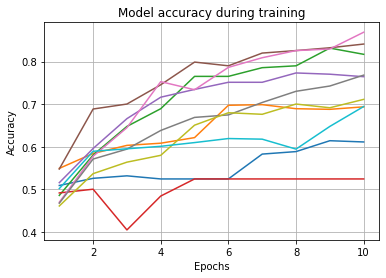

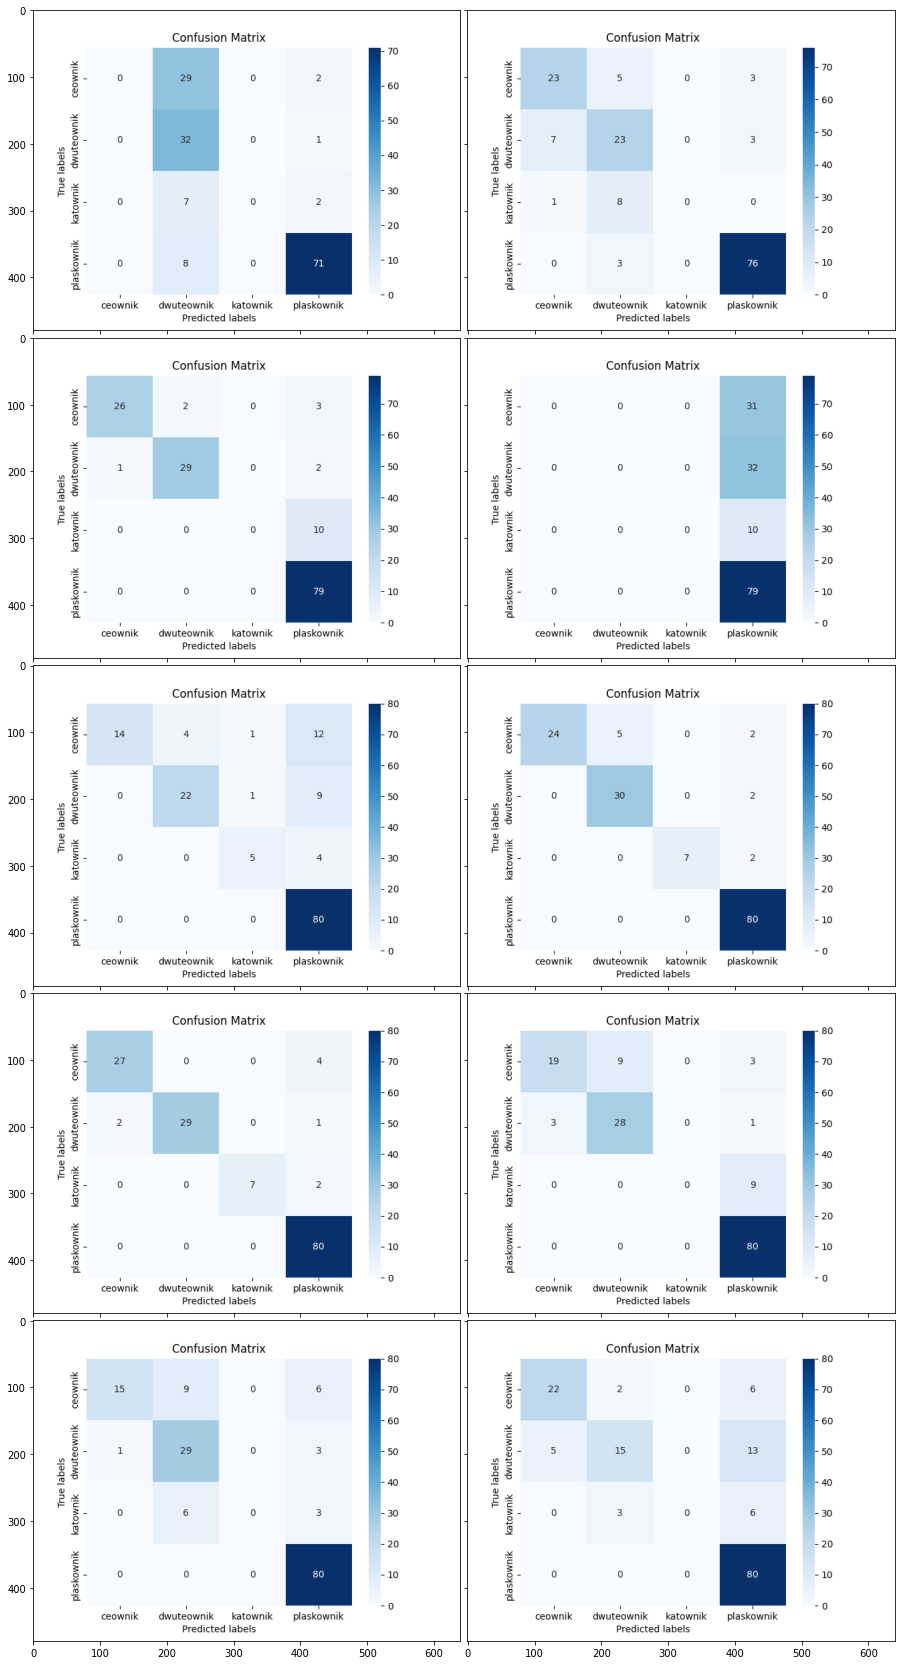

In [6]:
data = 'results/black_background_data_resnet50_lr001'
compare_train_and_test_acc(data, black_train_results, black_test_results)
show_training_history(data)
show_confusion_matrix(data)

In [7]:
show_misclassified(data)

Fold: 1


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00005-view04.png,ceownik,dwuteownik,0.251555,0.253999,0.242612,0.251834
1,ceownik_00006-view02.png,ceownik,dwuteownik,0.251555,0.253999,0.242612,0.251834
2,ceownik_00008-view03.png,ceownik,dwuteownik,0.251555,0.253999,0.242612,0.251834
3,ceownik_00009-view01.png,ceownik,dwuteownik,0.251555,0.253999,0.242612,0.251834
4,ceownik_00009-view03.png,ceownik,dwuteownik,0.251555,0.253999,0.242612,0.251834
5,ceownik_00013-view02.png,ceownik,dwuteownik,0.251555,0.253999,0.242612,0.251834
6,ceownik_00014-view04.png,ceownik,dwuteownik,0.251555,0.253999,0.242612,0.251834
7,ceownik_00015-view02.png,ceownik,dwuteownik,0.251555,0.253999,0.242612,0.251834
8,ceownik_00016-view01.png,ceownik,dwuteownik,0.251555,0.253999,0.242612,0.251834
9,ceownik_00020-view03.png,ceownik,dwuteownik,0.251555,0.253999,0.242612,0.251834


Fold: 2


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00003-view02.png,ceownik,plaskownik,0.255520,0.266939,0.166756,0.310784
1,ceownik_00053-view01.png,ceownik,plaskownik,0.279700,0.250216,0.182253,0.287831
2,ceownik_00053-view03.png,ceownik,dwuteownik,0.247782,0.253321,0.248036,0.250861
3,ceownik_00054-view02.png,ceownik,plaskownik,0.098902,0.106093,0.019423,0.775583
4,ceownik_00058-view02.png,ceownik,dwuteownik,0.247782,0.253321,0.248036,0.250861
5,ceownik_00069-view01.png,ceownik,dwuteownik,0.247782,0.253321,0.248036,0.250861
6,ceownik_00069-view03.png,ceownik,dwuteownik,0.247782,0.253321,0.248036,0.250861
7,ceownik_00077-view04.png,ceownik,dwuteownik,0.247782,0.253321,0.248036,0.250861
8,dwuteownik_00003-view01.png,dwuteownik,ceownik,0.259968,0.254231,0.238358,0.247443
9,dwuteownik_00020-view02.png,dwuteownik,ceownik,0.710730,0.162565,0.036872,0.089834


Fold: 3


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00017-view01.png,ceownik,dwuteownik,0.371134,0.620739,0.000241,0.007886
1,ceownik_00038-view04.png,ceownik,plaskownik,0.425178,0.011412,0.056279,0.507131
2,ceownik_00048-view04.png,ceownik,dwuteownik,0.373910,0.613716,0.000489,0.011885
3,ceownik_00055-view03.png,ceownik,plaskownik,0.255750,0.020870,0.037612,0.685768
4,ceownik_00063-view01.png,ceownik,plaskownik,0.022745,0.002893,0.000065,0.974297
5,dwuteownik_00024-view01.png,dwuteownik,plaskownik,0.187562,0.014613,0.020721,0.777105
6,dwuteownik_00042-view03.png,dwuteownik,plaskownik,0.141358,0.012347,0.013432,0.832863
7,dwuteownik_00083-view02.png,dwuteownik,ceownik,0.553925,0.438884,0.000118,0.007073
8,katownik_00008-view01.png,katownik,plaskownik,0.322236,0.142804,0.209897,0.325063
9,katownik_00008-view03.png,katownik,plaskownik,0.272942,0.212264,0.240275,0.274519


Fold: 4


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00005-view01.png,ceownik,plaskownik,0.116746,0.131751,0.223488,0.528015
1,ceownik_00007-view03.png,ceownik,plaskownik,0.249736,0.250045,0.239952,0.260267
2,ceownik_00008-view01.png,ceownik,plaskownik,0.249736,0.250045,0.239952,0.260267
3,ceownik_00010-view01.png,ceownik,plaskownik,0.249736,0.250045,0.239952,0.260267
4,ceownik_00011-view03.png,ceownik,plaskownik,0.249736,0.250045,0.239952,0.260267
...,...,...,...,...,...,...,...
68,katownik_00018-view02.png,katownik,plaskownik,0.249736,0.250045,0.239952,0.260267
69,katownik_00020-view04.png,katownik,plaskownik,0.095771,0.110727,0.210745,0.582756
70,katownik_00022-view01.png,katownik,plaskownik,0.249736,0.250045,0.239952,0.260267
71,katownik_00023-view01.png,katownik,plaskownik,0.031571,0.040972,0.135144,0.792313


Fold: 5


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00015-view03.png,ceownik,plaskownik,0.275133,0.209133,0.160983,0.354751
1,ceownik_00017-view03.png,ceownik,plaskownik,0.261342,0.190302,0.150719,0.397637
2,ceownik_00018-view01.png,ceownik,dwuteownik,0.250858,0.258084,0.244471,0.246588
3,ceownik_00018-view04.png,ceownik,dwuteownik,0.250858,0.258084,0.244471,0.246588
4,ceownik_00040-view01.png,ceownik,plaskownik,0.298990,0.145983,0.076410,0.478617
5,ceownik_00041-view01.png,ceownik,plaskownik,0.257453,0.251828,0.229150,0.261569
6,ceownik_00048-view01.png,ceownik,plaskownik,0.278299,0.225329,0.176397,0.319976
7,ceownik_00050-view03.png,ceownik,plaskownik,0.283904,0.215376,0.160091,0.340629
8,ceownik_00051-view02.png,ceownik,plaskownik,0.180654,0.111863,0.106023,0.601460
9,ceownik_00051-view04.png,ceownik,katownik,0.134153,0.184169,0.359437,0.322241


Fold: 6


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00002-view02.png,ceownik,dwuteownik,0.214087,0.355977,0.089655,0.340281
1,ceownik_00003-view04.png,ceownik,dwuteownik,0.252938,0.567825,0.042638,0.136598
2,ceownik_00005-view02.png,ceownik,dwuteownik,0.285653,0.378795,0.048341,0.287211
3,ceownik_00006-view03.png,ceownik,plaskownik,0.214684,0.178935,0.206770,0.399611
4,ceownik_00017-view04.png,ceownik,dwuteownik,0.322777,0.642910,0.007677,0.026635
5,ceownik_00018-view03.png,ceownik,dwuteownik,0.349460,0.375138,0.083725,0.191677
6,ceownik_00075-view01.png,ceownik,plaskownik,0.154530,0.003350,0.029610,0.812510
7,dwuteownik_00023-view02.png,dwuteownik,plaskownik,0.105978,0.244789,0.225285,0.423947
8,dwuteownik_00046-view03.png,dwuteownik,plaskownik,0.309547,0.212173,0.147234,0.331046
9,katownik_00003-view03.png,katownik,plaskownik,0.168768,0.006386,0.292844,0.532002


Fold: 7


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00002-view03.png,ceownik,plaskownik,0.271231,0.059735,0.003794,0.665240
1,ceownik_00003-view03.png,ceownik,plaskownik,0.333726,0.099249,0.006036,0.560990
2,ceownik_00055-view04.png,ceownik,plaskownik,0.067561,0.023766,0.001011,0.907663
3,ceownik_00062-view03.png,ceownik,plaskownik,0.314162,0.026377,0.016883,0.642578
4,dwuteownik_00027-view02.png,dwuteownik,plaskownik,0.038303,0.000719,0.001199,0.959779
5,dwuteownik_00080-view01.png,dwuteownik,ceownik,0.721941,0.266190,0.000125,0.011745
6,dwuteownik_00080-view03.png,dwuteownik,ceownik,0.721759,0.266612,0.000118,0.011511
7,katownik_00012-view02.png,katownik,plaskownik,0.074916,0.008540,0.080745,0.835799
8,katownik_00018-view01.png,katownik,plaskownik,0.111453,0.038231,0.349356,0.500960


Fold: 8


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00002-view04.png,ceownik,plaskownik,0.164071,0.297578,0.015743,0.522607
1,ceownik_00004-view01.png,ceownik,dwuteownik,0.310775,0.357517,0.016616,0.315092
2,ceownik_00005-view03.png,ceownik,dwuteownik,0.233241,0.390556,0.059002,0.317202
3,ceownik_00015-view01.png,ceownik,dwuteownik,0.439494,0.501724,0.001657,0.057125
4,ceownik_00035-view01.png,ceownik,dwuteownik,0.337215,0.585447,0.000495,0.076843
5,ceownik_00035-view03.png,ceownik,dwuteownik,0.320037,0.620923,0.000331,0.058709
6,ceownik_00050-view02.png,ceownik,dwuteownik,0.259658,0.516587,0.002426,0.221328
7,ceownik_00055-view02.png,ceownik,plaskownik,0.056168,0.094275,0.011214,0.838343
8,ceownik_00063-view02.png,ceownik,plaskownik,0.322969,0.260842,0.019768,0.396421
9,ceownik_00067-view01.png,ceownik,dwuteownik,0.250614,0.583982,0.002736,0.162668


Fold: 9


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00002-view01.png,ceownik,plaskownik,0.229707,0.234479,0.203712,0.332102
1,ceownik_00003-view01.png,ceownik,plaskownik,0.236160,0.241832,0.216049,0.305958
2,ceownik_00022-view01.png,ceownik,dwuteownik,0.248627,0.256448,0.244186,0.250739
3,ceownik_00022-view04.png,ceownik,dwuteownik,0.248627,0.256448,0.244186,0.250739
4,ceownik_00036-view04.png,ceownik,dwuteownik,0.248627,0.256448,0.244186,0.250739
5,ceownik_00041-view03.png,ceownik,plaskownik,0.193615,0.194788,0.148914,0.462684
6,ceownik_00051-view01.png,ceownik,dwuteownik,0.248627,0.256448,0.244186,0.250739
7,ceownik_00052-view01.png,ceownik,plaskownik,0.202603,0.204503,0.160948,0.431946
8,ceownik_00053-view02.png,ceownik,plaskownik,0.114522,0.112103,0.067336,0.706039
9,ceownik_00055-view01.png,ceownik,plaskownik,0.064885,0.062162,0.030895,0.842058


Fold: 10


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00004-view02.png,ceownik,plaskownik,0.197591,0.236596,0.000982,0.564830
1,ceownik_00004-view03.png,ceownik,plaskownik,0.206732,0.250276,0.001771,0.541221
2,ceownik_00004-view04.png,ceownik,plaskownik,0.206509,0.220129,0.000676,0.572686
3,ceownik_00020-view02.png,ceownik,dwuteownik,0.255884,0.256518,0.245602,0.241995
4,ceownik_00021-view01.png,ceownik,dwuteownik,0.255884,0.256518,0.245602,0.241995
5,ceownik_00048-view03.png,ceownik,plaskownik,0.269453,0.298264,0.036952,0.395332
6,ceownik_00054-view03.png,ceownik,plaskownik,0.095532,0.084980,0.000007,0.819481
7,ceownik_00075-view02.png,ceownik,plaskownik,0.256121,0.110761,0.010014,0.623104
8,dwuteownik_00004-view01.png,dwuteownik,ceownik,0.279692,0.256898,0.207443,0.255967
9,dwuteownik_00004-view03.png,dwuteownik,ceownik,0.297924,0.255597,0.180719,0.265760


# Białe tło <a class="anchor" id="white"></a>

## Białe tło - Xception <a class="anchor" id="white-xception"></a>

,0,1,2,3,4,5,6,7,8,9,10
,Fold: 1,Fold: 2,Fold: 3,Fold: 4,Fold: 5,Fold: 6,Fold: 7,Fold: 8,Fold: 9,Fold: 10,Mean
Training ACC,0.90424,0.843567,0.871345,0.877924,0.915205,0.913012,0.927632,0.884503,0.89693,0.874269,0.890863
Test Acc,0.907895,0.888158,0.934211,0.940789,0.947368,0.947368,0.940789,0.907895,0.934211,0.934211,0.928289


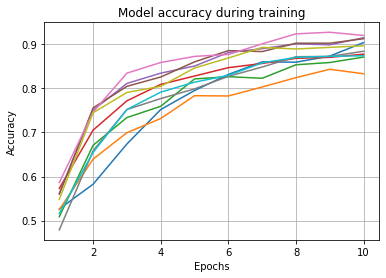

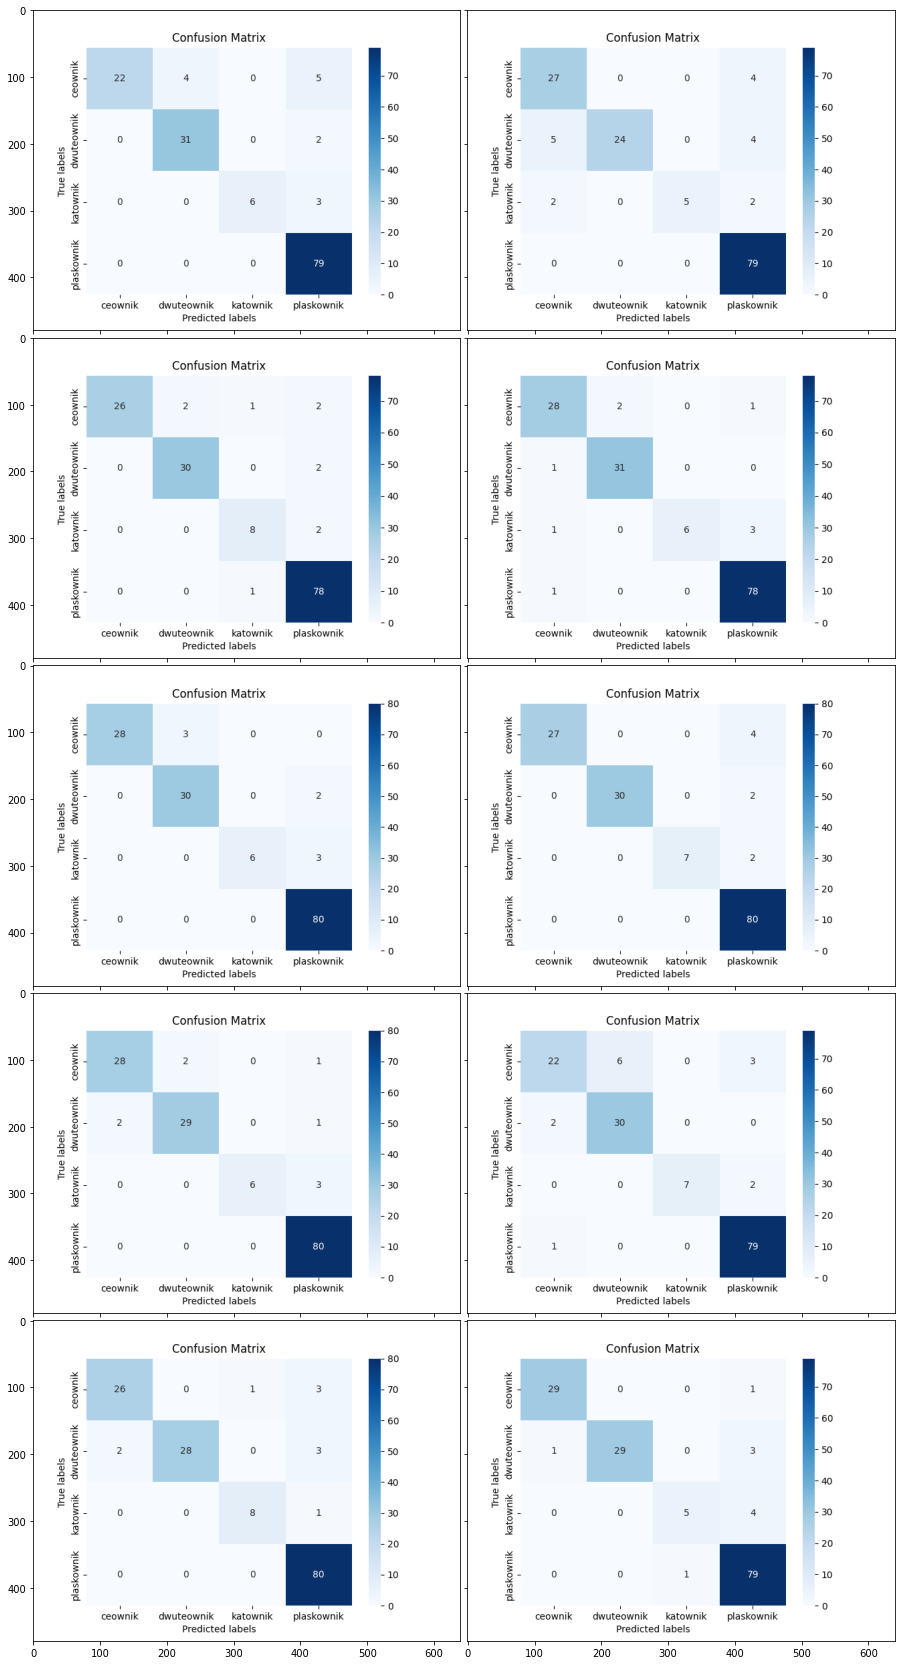

In [8]:
data = 'results/white_background_data_xception'
compare_train_and_test_acc(data, white_train_results, white_test_results)
show_training_history(data)
show_confusion_matrix(data)

In [9]:
show_misclassified(data)

Fold: 1


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00005-view04.png,ceownik,plaskownik,0.085595,0.324692,0.060630,0.529084
1,ceownik_00006-view02.png,ceownik,plaskownik,0.161671,0.336526,0.149625,0.352178
2,ceownik_00015-view02.png,ceownik,dwuteownik,0.450099,0.456070,0.007287,0.086544
3,ceownik_00016-view01.png,ceownik,dwuteownik,0.382014,0.571654,0.007524,0.038808
4,ceownik_00054-view04.png,ceownik,plaskownik,0.087013,0.085818,0.034941,0.792227
5,ceownik_00063-view04.png,ceownik,plaskownik,0.189426,0.155129,0.017998,0.637447
6,ceownik_00067-view02.png,ceownik,dwuteownik,0.056930,0.933819,0.001370,0.007882
7,ceownik_00068-view03.png,ceownik,plaskownik,0.147711,0.029416,0.029692,0.793181
8,ceownik_00072-view02.png,ceownik,dwuteownik,0.212602,0.735183,0.006676,0.045539
9,dwuteownik_00042-view02.png,dwuteownik,plaskownik,0.194806,0.135375,0.038875,0.630944


Fold: 2


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00003-view02.png,ceownik,plaskownik,0.091236,0.097710,0.144146,0.666907
1,ceownik_00053-view01.png,ceownik,plaskownik,0.074405,0.160816,0.312441,0.452338
2,ceownik_00053-view03.png,ceownik,plaskownik,0.075603,0.151293,0.291661,0.481444
3,ceownik_00054-view02.png,ceownik,plaskownik,0.081499,0.083966,0.146564,0.687972
4,dwuteownik_00022-view03.png,dwuteownik,ceownik,0.639409,0.233979,0.026048,0.100563
5,dwuteownik_00027-view01.png,dwuteownik,plaskownik,0.184371,0.266704,0.113074,0.435851
6,dwuteownik_00029-view02.png,dwuteownik,ceownik,0.583753,0.339536,0.009345,0.067367
7,dwuteownik_00030-view02.png,dwuteownik,ceownik,0.748341,0.204432,0.004868,0.042359
8,dwuteownik_00033-view01.png,dwuteownik,plaskownik,0.113261,0.192792,0.059340,0.634606
9,dwuteownik_00043-view01.png,dwuteownik,plaskownik,0.066535,0.167707,0.060476,0.705283


Fold: 3


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00017-view01.png,ceownik,katownik,0.025576,0.144099,0.566524,0.263802
1,ceownik_00048-view04.png,ceownik,dwuteownik,0.193421,0.696650,0.026109,0.083821
2,ceownik_00055-view03.png,ceownik,plaskownik,0.055327,0.187168,0.166535,0.590971
3,ceownik_00063-view01.png,ceownik,plaskownik,0.095941,0.071243,0.043856,0.788960
4,ceownik_00072-view04.png,ceownik,dwuteownik,0.276503,0.638386,0.014115,0.070996
5,dwuteownik_00024-view01.png,dwuteownik,plaskownik,0.097030,0.259264,0.104862,0.538844
6,dwuteownik_00042-view03.png,dwuteownik,plaskownik,0.106085,0.173686,0.088257,0.631973
7,katownik_00010-view03.png,katownik,plaskownik,0.000145,0.001145,0.007362,0.991348
8,katownik_00020-view01.png,katownik,plaskownik,0.131334,0.077294,0.229070,0.562302
9,plaskownik_00171-view01.png,plaskownik,katownik,0.002073,0.026946,0.676325,0.294656


Fold: 4


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00005-view01.png,ceownik,dwuteownik,0.333837,0.539579,0.012495,0.114089
1,ceownik_00048-view02.png,ceownik,dwuteownik,0.294443,0.686404,0.000430,0.018723
2,ceownik_00054-view01.png,ceownik,plaskownik,0.071741,0.028794,0.004243,0.895221
3,dwuteownik_00030-view03.png,dwuteownik,ceownik,0.519659,0.470658,0.000070,0.009613
4,katownik_00011-view02.png,katownik,plaskownik,0.000150,0.000062,0.008167,0.991622
5,katownik_00015-view04.png,katownik,ceownik,0.441409,0.085797,0.085738,0.387056
6,katownik_00023-view01.png,katownik,plaskownik,0.054206,0.041806,0.012379,0.891609
7,katownik_00023-view03.png,katownik,plaskownik,0.098649,0.017842,0.191782,0.691727
8,plaskownik_00031-view03.png,plaskownik,ceownik,0.504276,0.031009,0.000183,0.464531


Fold: 5


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00018-view01.png,ceownik,dwuteownik,0.124604,0.873013,0.000313,0.002070
1,ceownik_00050-view03.png,ceownik,dwuteownik,0.493064,0.503827,0.000949,0.002160
2,ceownik_00072-view03.png,ceownik,dwuteownik,0.272248,0.701085,0.000632,0.026036
3,dwuteownik_00024-view03.png,dwuteownik,plaskownik,0.087431,0.016265,0.000549,0.895755
4,dwuteownik_00042-view01.png,dwuteownik,plaskownik,0.089329,0.019340,0.000558,0.890772
5,katownik_00017-view01.png,katownik,plaskownik,0.033412,0.021696,0.186943,0.757949
6,katownik_00019-view03.png,katownik,plaskownik,0.025015,0.010967,0.098330,0.865688
7,katownik_00023-view04.png,katownik,plaskownik,0.087986,0.075654,0.007239,0.829121


Fold: 6


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00003-view04.png,ceownik,plaskownik,0.170457,0.124472,0.037113,0.667959
1,ceownik_00006-view04.png,ceownik,plaskownik,0.072774,0.002724,0.029945,0.894557
2,ceownik_00017-view04.png,ceownik,plaskownik,0.330086,0.021231,0.088065,0.560618
3,ceownik_00075-view01.png,ceownik,plaskownik,0.000646,0.000629,0.000021,0.998704
4,dwuteownik_00046-view03.png,dwuteownik,plaskownik,0.335356,0.277300,0.010993,0.376352
5,dwuteownik_00082-view04.png,dwuteownik,plaskownik,0.006066,0.051804,0.010166,0.931964
6,katownik_00003-view03.png,katownik,plaskownik,0.017951,0.001618,0.084308,0.896123
7,katownik_00015-view03.png,katownik,plaskownik,0.008756,0.009372,0.057325,0.924547


Fold: 7


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00002-view03.png,ceownik,dwuteownik,0.202974,0.689261,0.001533,0.106232
1,ceownik_00003-view03.png,ceownik,dwuteownik,0.174348,0.599640,0.004136,0.221876
2,ceownik_00055-view04.png,ceownik,plaskownik,0.090920,0.216908,0.005304,0.686868
3,dwuteownik_00027-view02.png,dwuteownik,plaskownik,0.003337,0.067005,0.127852,0.801805
4,dwuteownik_00080-view01.png,dwuteownik,ceownik,0.692499,0.261801,0.000885,0.044816
5,dwuteownik_00080-view03.png,dwuteownik,ceownik,0.698555,0.255684,0.000918,0.044843
6,katownik_00012-view02.png,katownik,plaskownik,0.000650,0.004116,0.054247,0.940986
7,katownik_00016-view04.png,katownik,plaskownik,0.000287,0.000043,0.139925,0.859745
8,katownik_00018-view01.png,katownik,plaskownik,0.003011,0.006801,0.328510,0.661678


Fold: 8


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00005-view03.png,ceownik,dwuteownik,0.184545,0.737409,0.031780,0.046266
1,ceownik_00015-view01.png,ceownik,dwuteownik,0.201188,0.796474,0.001029,0.001309
2,ceownik_00035-view01.png,ceownik,dwuteownik,0.068848,0.930387,0.000046,0.000720
3,ceownik_00035-view03.png,ceownik,dwuteownik,0.097065,0.902778,0.000064,0.000093
4,ceownik_00053-view04.png,ceownik,plaskownik,0.204433,0.055945,0.284385,0.455237
5,ceownik_00055-view02.png,ceownik,plaskownik,0.037750,0.010516,0.003594,0.948140
6,ceownik_00063-view02.png,ceownik,plaskownik,0.032395,0.133864,0.002420,0.831321
7,ceownik_00067-view01.png,ceownik,dwuteownik,0.159642,0.820094,0.004265,0.015998
8,ceownik_00075-view03.png,ceownik,dwuteownik,0.374234,0.614732,0.000920,0.010113
9,dwuteownik_00083-view01.png,dwuteownik,ceownik,0.890530,0.101386,0.000168,0.007915


Fold: 9


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00002-view01.png,ceownik,plaskownik,0.437769,0.063819,0.015114,0.483297
1,ceownik_00003-view01.png,ceownik,plaskownik,0.059941,0.017734,0.016992,0.905333
2,ceownik_00053-view02.png,ceownik,katownik,0.216878,0.008083,0.534833,0.240205
3,ceownik_00055-view01.png,ceownik,plaskownik,0.060663,0.002255,0.007400,0.929682
4,dwuteownik_00021-view02.png,dwuteownik,ceownik,0.724377,0.208676,0.012263,0.054684
5,dwuteownik_00022-view02.png,dwuteownik,ceownik,0.629253,0.260481,0.055908,0.054358
6,dwuteownik_00024-view02.png,dwuteownik,plaskownik,0.017596,0.005510,0.012315,0.964579
7,dwuteownik_00082-view01.png,dwuteownik,plaskownik,0.024956,0.479501,0.004991,0.490552
8,dwuteownik_00082-view03.png,dwuteownik,plaskownik,0.001393,0.218967,0.012985,0.766656
9,katownik_00019-view02.png,katownik,plaskownik,0.021399,0.000379,0.381089,0.597133


Fold: 10


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00054-view03.png,ceownik,plaskownik,0.324902,0.054079,0.011481,0.609537
1,dwuteownik_00023-view03.png,dwuteownik,plaskownik,0.092160,0.174531,0.050187,0.683122
2,dwuteownik_00027-view03.png,dwuteownik,plaskownik,0.143868,0.031693,0.119292,0.705147
3,dwuteownik_00027-view04.png,dwuteownik,plaskownik,0.121834,0.185821,0.036903,0.655442
4,dwuteownik_00083-view04.png,dwuteownik,ceownik,0.788207,0.202348,0.000195,0.009251
5,katownik_00005-view01.png,katownik,plaskownik,0.052832,0.002247,0.264256,0.680665
6,katownik_00013-view03.png,katownik,plaskownik,0.025597,0.001271,0.171072,0.802060
7,katownik_00014-view03.png,katownik,plaskownik,0.014978,0.000306,0.055829,0.928887
8,katownik_00016-view02.png,katownik,plaskownik,0.010760,0.000388,0.036508,0.952344
9,plaskownik_00118-view01.png,plaskownik,katownik,0.056337,0.001442,0.629750,0.312470


## Białe tło - VGG16 <a class="anchor" id="white-vgg16"></a>

,0,1,2,3,4,5,6,7,8,9,10
,Fold: 1,Fold: 2,Fold: 3,Fold: 4,Fold: 5,Fold: 6,Fold: 7,Fold: 8,Fold: 9,Fold: 10,Mean
Training ACC,0.866959,0.819444,0.755117,0.858918,0.898392,0.869152,0.833333,0.848684,0.767544,0.831871,0.834942
Test Acc,0.875,0.875,0.75,0.888158,0.934211,0.894737,0.842105,0.835526,0.769737,0.888158,0.855263


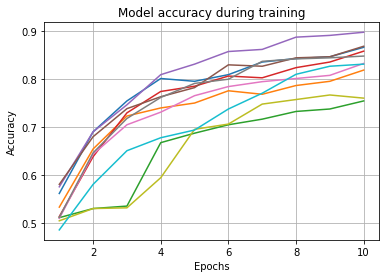

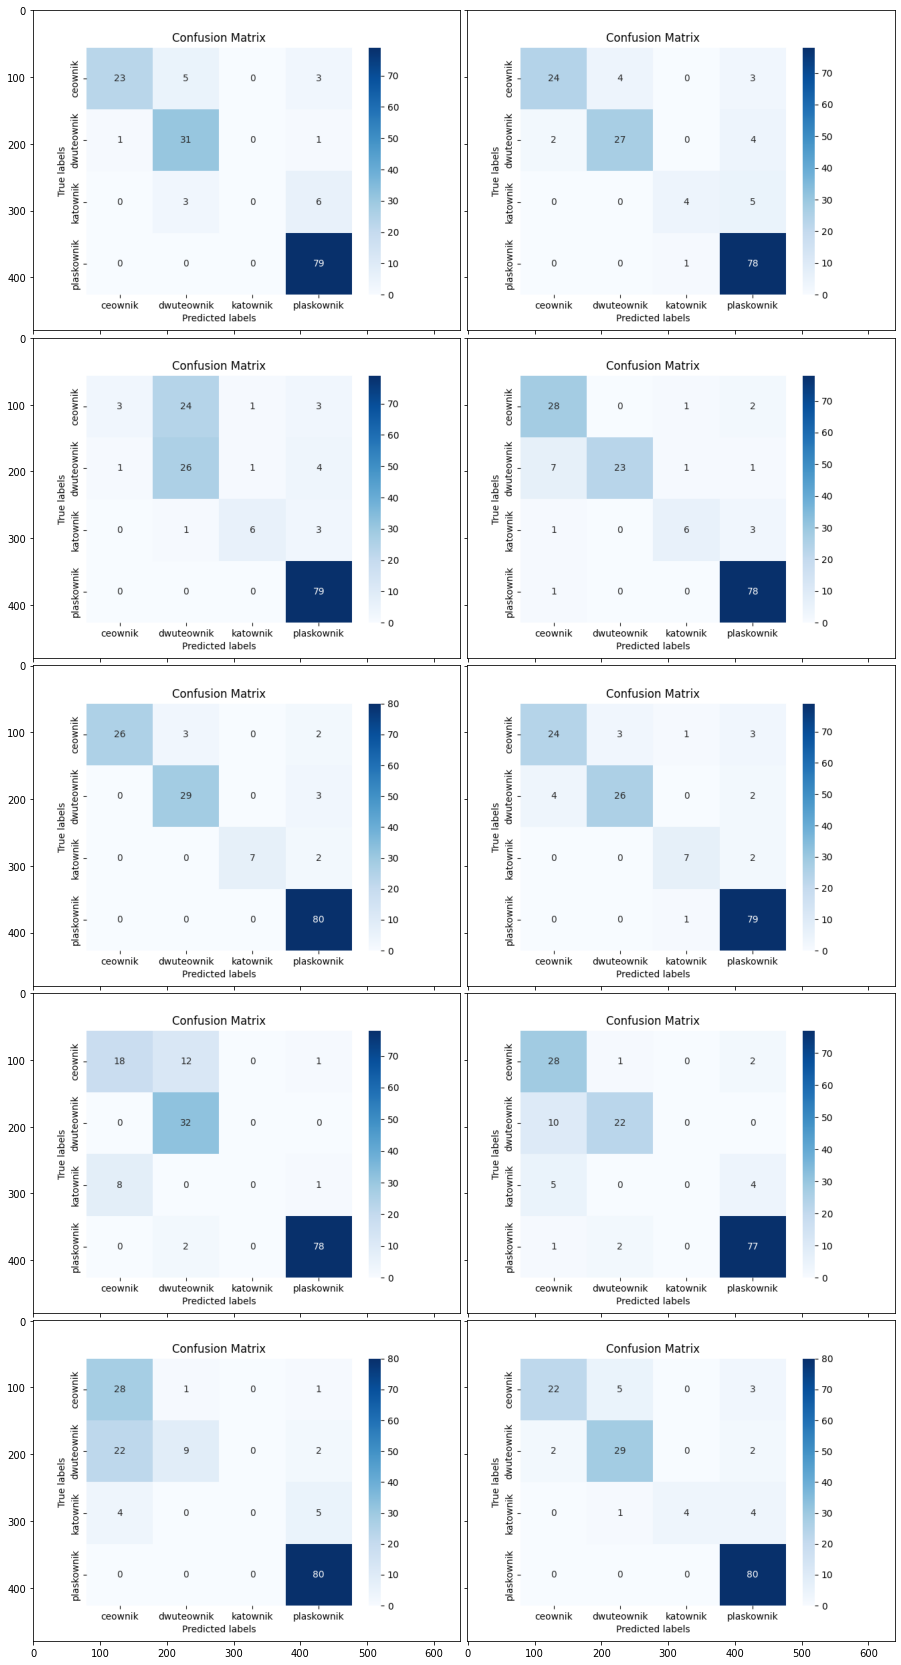

In [10]:
data = 'results/black_background_data_vgg16'
compare_train_and_test_acc(data, white_train_results, white_test_results)
show_training_history(data)
show_confusion_matrix(data)

In [11]:
show_misclassified(data)

Fold: 1


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00005-view04.png,ceownik,dwuteownik,0.278027,0.471888,0.083253,0.166832
1,ceownik_00006-view02.png,ceownik,plaskownik,0.253400,0.111863,0.178524,0.456214
2,ceownik_00015-view02.png,ceownik,dwuteownik,0.309170,0.588137,0.012586,0.090108
3,ceownik_00054-view04.png,ceownik,plaskownik,0.048879,0.001109,0.003842,0.946171
4,ceownik_00058-view03.png,ceownik,dwuteownik,0.268812,0.387248,0.141402,0.202538
5,ceownik_00063-view04.png,ceownik,dwuteownik,0.112029,0.781294,0.000384,0.106293
6,ceownik_00068-view03.png,ceownik,plaskownik,0.017881,0.003599,0.024036,0.954484
7,ceownik_00072-view02.png,ceownik,dwuteownik,0.157993,0.833834,0.000106,0.008067
8,dwuteownik_00042-view02.png,dwuteownik,ceownik,0.453460,0.273085,0.020766,0.252689
9,dwuteownik_00042-view04.png,dwuteownik,plaskownik,0.023250,0.011714,0.122590,0.842447


Fold: 2


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00021-view03.png,ceownik,dwuteownik,0.276787,0.720615,0.001128,0.001470
1,ceownik_00038-view01.png,ceownik,dwuteownik,0.244742,0.754327,0.000395,0.000537
2,ceownik_00053-view01.png,ceownik,plaskownik,0.266171,0.006600,0.001145,0.726083
3,ceownik_00053-view03.png,ceownik,plaskownik,0.385600,0.004098,0.000278,0.610025
4,ceownik_00054-view02.png,ceownik,plaskownik,0.266293,0.014235,0.000814,0.718658
5,ceownik_00069-view03.png,ceownik,dwuteownik,0.276380,0.721055,0.001113,0.001452
6,ceownik_00073-view04.png,ceownik,dwuteownik,0.229510,0.769935,0.000233,0.000323
7,dwuteownik_00027-view01.png,dwuteownik,plaskownik,0.008760,0.004090,0.061256,0.925893
8,dwuteownik_00033-view01.png,dwuteownik,plaskownik,0.001158,0.005841,0.000009,0.992992
9,dwuteownik_00043-view01.png,dwuteownik,plaskownik,0.154170,0.026571,0.000014,0.819245


Fold: 3


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00001-view01.png,ceownik,dwuteownik,0.279022,0.287781,0.203115,0.230081
1,ceownik_00007-view04.png,ceownik,dwuteownik,0.279022,0.287781,0.203115,0.230081
2,ceownik_00008-view02.png,ceownik,dwuteownik,0.279022,0.287781,0.203115,0.230081
3,ceownik_00014-view03.png,ceownik,dwuteownik,0.279022,0.287781,0.203115,0.230081
4,ceownik_00017-view01.png,ceownik,dwuteownik,0.279022,0.287781,0.203115,0.230081
5,ceownik_00018-view02.png,ceownik,dwuteownik,0.279022,0.287781,0.203115,0.230081
6,ceownik_00019-view03.png,ceownik,dwuteownik,0.279022,0.287781,0.203115,0.230081
7,ceownik_00023-view04.png,ceownik,dwuteownik,0.279022,0.287781,0.203115,0.230081
8,ceownik_00026-view04.png,ceownik,dwuteownik,0.279022,0.287781,0.203115,0.230081
9,ceownik_00029-view03.png,ceownik,dwuteownik,0.279022,0.287781,0.203115,0.230081


Fold: 4


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00005-view01.png,ceownik,katownik,0.117890,0.129599,0.426611,0.325901
1,ceownik_00049-view03.png,ceownik,plaskownik,0.230664,0.054591,0.035719,0.679026
2,ceownik_00054-view01.png,ceownik,plaskownik,0.104788,0.001417,0.000089,0.893706
3,dwuteownik_00001-view02.png,dwuteownik,ceownik,0.917211,0.072651,0.000003,0.010135
4,dwuteownik_00008-view03.png,dwuteownik,ceownik,0.709902,0.272219,0.000025,0.017854
5,dwuteownik_00009-view01.png,dwuteownik,ceownik,0.712261,0.274745,0.000010,0.012983
6,dwuteownik_00010-view01.png,dwuteownik,ceownik,0.740266,0.246098,0.000011,0.013626
7,dwuteownik_00024-view04.png,dwuteownik,ceownik,0.584280,0.156616,0.006279,0.252824
8,dwuteownik_00031-view03.png,dwuteownik,katownik,0.084424,0.125555,0.450647,0.339374
9,dwuteownik_00043-view02.png,dwuteownik,plaskownik,0.185606,0.074744,0.005856,0.733794


Fold: 5


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00018-view01.png,ceownik,dwuteownik,0.235409,0.694422,0.001539,0.068630
1,ceownik_00018-view04.png,ceownik,dwuteownik,0.282987,0.505072,0.032465,0.179476
2,ceownik_00050-view04.png,ceownik,plaskownik,0.436428,0.120656,0.000491,0.442425
3,ceownik_00063-view03.png,ceownik,plaskownik,0.139957,0.021880,0.000021,0.838142
4,ceownik_00072-view03.png,ceownik,dwuteownik,0.272731,0.566710,0.015397,0.145162
5,dwuteownik_00024-view03.png,dwuteownik,plaskownik,0.249401,0.329919,0.061457,0.359222
6,dwuteownik_00042-view01.png,dwuteownik,plaskownik,0.238068,0.328577,0.046935,0.386420
7,dwuteownik_00046-view01.png,dwuteownik,plaskownik,0.000591,0.004772,0.000105,0.994531
8,katownik_00019-view03.png,katownik,plaskownik,0.002502,0.000689,0.245556,0.751253
9,katownik_00023-view04.png,katownik,plaskownik,0.006946,0.002041,0.021178,0.969835


Fold: 6


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00002-view02.png,ceownik,dwuteownik,0.304719,0.498255,0.129661,0.067365
1,ceownik_00003-view04.png,ceownik,dwuteownik,0.273788,0.655578,0.059397,0.011237
2,ceownik_00005-view02.png,ceownik,plaskownik,0.239565,0.252245,0.245640,0.262550
3,ceownik_00006-view03.png,ceownik,plaskownik,0.239565,0.252245,0.245640,0.262550
4,ceownik_00006-view04.png,ceownik,katownik,0.078696,0.185300,0.384112,0.351892
5,ceownik_00017-view04.png,ceownik,dwuteownik,0.240722,0.730230,0.015653,0.013395
6,ceownik_00075-view01.png,ceownik,plaskownik,0.242975,0.061506,0.094501,0.601018
7,dwuteownik_00001-view03.png,dwuteownik,ceownik,0.597991,0.400966,0.000922,0.000121
8,dwuteownik_00023-view02.png,dwuteownik,ceownik,0.354935,0.347632,0.136781,0.160653
9,dwuteownik_00030-view01.png,dwuteownik,ceownik,0.564968,0.417357,0.006647,0.011028


Fold: 7


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00002-view03.png,ceownik,dwuteownik,0.271922,0.362984,0.144262,0.220832
1,ceownik_00003-view03.png,ceownik,dwuteownik,0.240317,0.536544,0.102843,0.120296
2,ceownik_00013-view01.png,ceownik,dwuteownik,0.287610,0.317530,0.193726,0.201134
3,ceownik_00019-view01.png,ceownik,dwuteownik,0.262930,0.456431,0.132319,0.148320
4,ceownik_00046-view03.png,ceownik,dwuteownik,0.288241,0.310742,0.197150,0.203867
5,ceownik_00055-view04.png,ceownik,plaskownik,0.099620,0.026777,0.070418,0.803185
6,ceownik_00057-view04.png,ceownik,dwuteownik,0.281204,0.367217,0.169994,0.181585
7,ceownik_00058-view01.png,ceownik,dwuteownik,0.221078,0.593514,0.084017,0.101391
8,ceownik_00058-view04.png,ceownik,dwuteownik,0.112894,0.832687,0.022376,0.032042
9,ceownik_00061-view03.png,ceownik,dwuteownik,0.266267,0.442614,0.137793,0.153326


Fold: 8


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00004-view01.png,ceownik,dwuteownik,0.365840,0.552248,0.035200,0.046712
1,ceownik_00055-view02.png,ceownik,plaskownik,0.156196,0.161301,0.213792,0.468710
2,ceownik_00063-view02.png,ceownik,plaskownik,0.187173,0.000149,0.091415,0.721263
3,dwuteownik_00018-view01.png,dwuteownik,ceownik,0.528342,0.471632,0.000013,0.000013
4,dwuteownik_00020-view01.png,dwuteownik,ceownik,0.671375,0.322857,0.003179,0.002590
5,dwuteownik_00025-view03.png,dwuteownik,ceownik,0.773272,0.226357,0.000207,0.000165
6,dwuteownik_00030-view04.png,dwuteownik,ceownik,0.620640,0.378250,0.000587,0.000522
7,dwuteownik_00059-view03.png,dwuteownik,ceownik,0.775544,0.224185,0.000151,0.000120
8,dwuteownik_00062-view02.png,dwuteownik,ceownik,0.965632,0.030088,0.002731,0.001550
9,dwuteownik_00069-view03.png,dwuteownik,ceownik,0.994551,0.005410,0.000029,0.000009


Fold: 9


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00051-view01.png,ceownik,dwuteownik,0.127402,0.544086,0.104182,0.224331
1,ceownik_00055-view01.png,ceownik,plaskownik,0.101741,0.060162,0.165356,0.672741
2,dwuteownik_00007-view03.png,dwuteownik,ceownik,0.277082,0.267509,0.218619,0.236790
3,dwuteownik_00008-view02.png,dwuteownik,ceownik,0.277082,0.267509,0.218619,0.236790
4,dwuteownik_00009-view04.png,dwuteownik,ceownik,0.277082,0.267509,0.218619,0.236790
5,dwuteownik_00010-view04.png,dwuteownik,ceownik,0.277082,0.267509,0.218619,0.236790
6,dwuteownik_00011-view03.png,dwuteownik,ceownik,0.277082,0.267509,0.218619,0.236790
7,dwuteownik_00012-view01.png,dwuteownik,ceownik,0.277082,0.267509,0.218619,0.236790
8,dwuteownik_00021-view02.png,dwuteownik,ceownik,0.277082,0.267509,0.218619,0.236790
9,dwuteownik_00022-view02.png,dwuteownik,ceownik,0.277082,0.267509,0.218619,0.236790


Fold: 10


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00004-view02.png,ceownik,dwuteownik,0.257006,0.454715,0.012236,0.276044
1,ceownik_00004-view03.png,ceownik,plaskownik,0.166364,0.114379,0.160653,0.558604
2,ceownik_00006-view01.png,ceownik,plaskownik,0.111406,0.025812,0.230223,0.632559
3,ceownik_00020-view02.png,ceownik,dwuteownik,0.365976,0.390631,0.072623,0.170770
4,ceownik_00048-view03.png,ceownik,dwuteownik,0.254958,0.263720,0.231433,0.249889
5,ceownik_00054-view03.png,ceownik,plaskownik,0.058997,0.016145,0.108723,0.816135
6,ceownik_00069-view04.png,ceownik,dwuteownik,0.356305,0.378963,0.083945,0.180788
7,ceownik_00075-view02.png,ceownik,dwuteownik,0.073115,0.907939,0.000190,0.018756
8,dwuteownik_00023-view03.png,dwuteownik,plaskownik,0.062552,0.010971,0.218958,0.707519
9,dwuteownik_00027-view03.png,dwuteownik,plaskownik,0.185436,0.137082,0.177115,0.500367


## Białe tło - ResNet50 <a class="anchor" id="white-resnet50"></a>

,0,1,2,3,4,5,6,7,8,9,10
,Fold: 1,Fold: 2,Fold: 3,Fold: 4,Fold: 5,Fold: 6,Fold: 7,Fold: 8,Fold: 9,Fold: 10,Mean
Training ACC,0.871345,0.873538,0.771199,0.858918,0.850146,0.891813,0.856725,0.894737,0.711988,0.850146,0.843056
Test Acc,0.888158,0.907895,0.809211,0.894737,0.881579,0.940789,0.921053,0.828947,0.769737,0.881579,0.872368


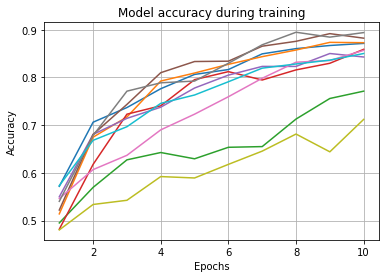

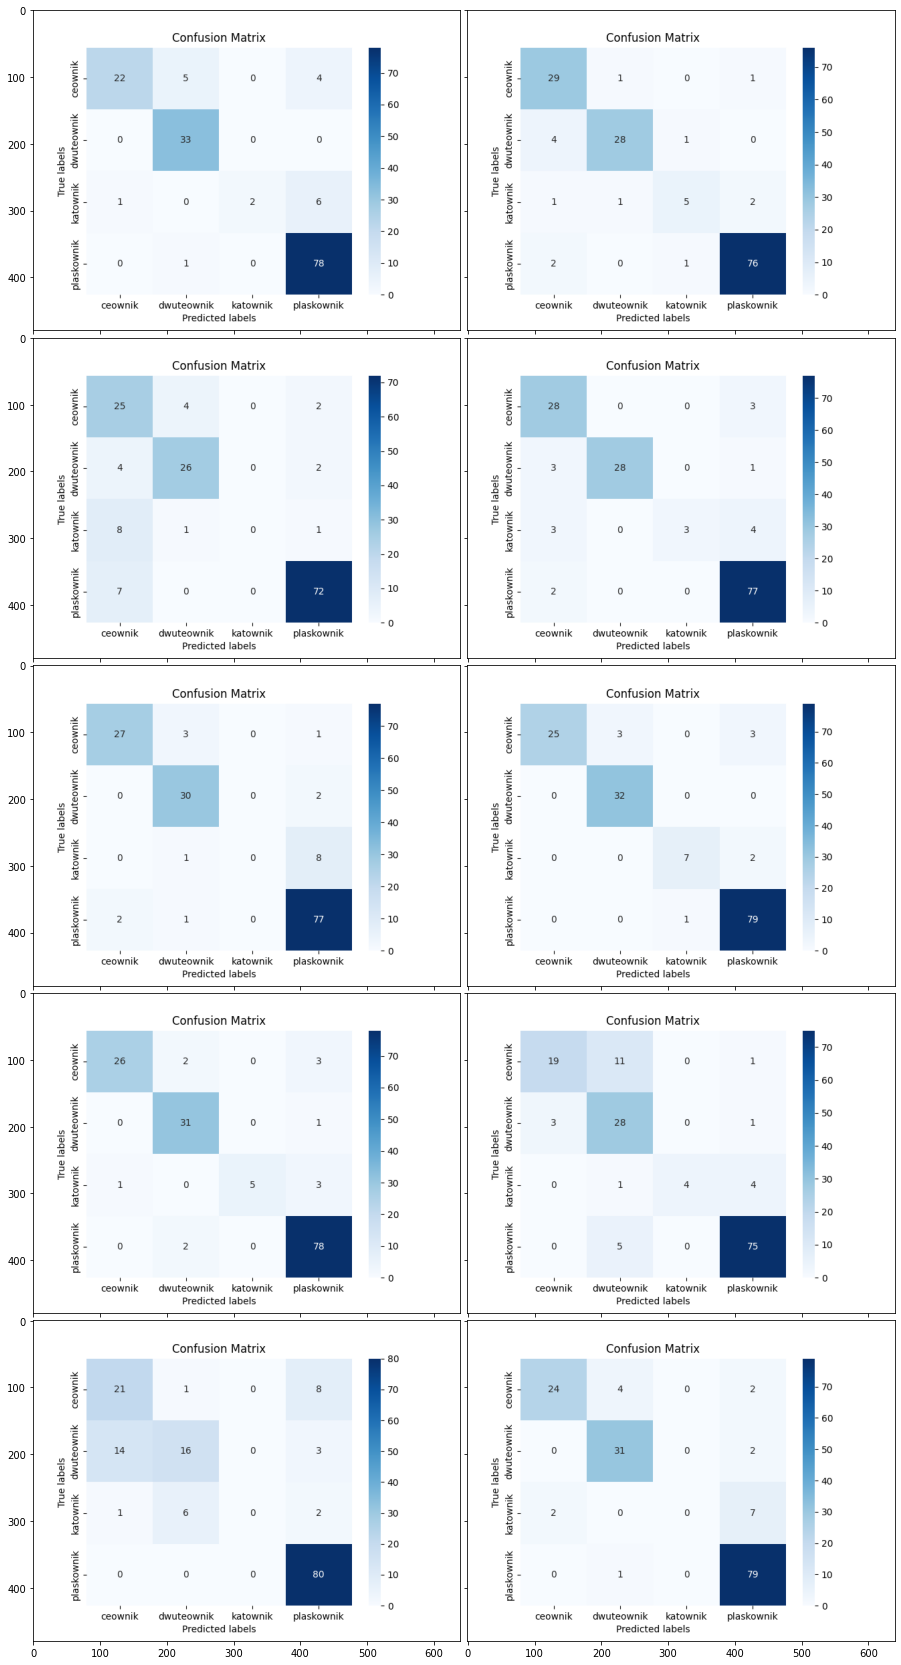

In [12]:
data = 'results/white_background_data_resnet50_lr_001'
compare_train_and_test_acc(data, white_train_results, white_test_results)
show_training_history(data)
show_confusion_matrix(data)

In [13]:
show_misclassified(data)

Fold: 1


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00005-view04.png,ceownik,plaskownik,0.161718,0.105309,0.140109,0.592865
1,ceownik_00006-view02.png,ceownik,plaskownik,0.253409,0.239479,0.250410,0.256702
2,ceownik_00052-view03.png,ceownik,dwuteownik,0.385823,0.486133,0.006840,0.121203
3,ceownik_00054-view04.png,ceownik,plaskownik,0.017976,0.010453,0.016206,0.955365
4,ceownik_00063-view04.png,ceownik,plaskownik,0.032145,0.139206,0.002543,0.826106
5,ceownik_00067-view02.png,ceownik,dwuteownik,0.119450,0.865427,0.000850,0.014273
6,ceownik_00070-view01.png,ceownik,dwuteownik,0.451590,0.453647,0.014692,0.080071
7,ceownik_00072-view01.png,ceownik,dwuteownik,0.271777,0.668541,0.006612,0.053070
8,ceownik_00072-view02.png,ceownik,dwuteownik,0.057287,0.935248,0.000089,0.007376
9,katownik_00004-view03.png,katownik,plaskownik,0.258513,0.048730,0.156827,0.535931


Fold: 2


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00003-view02.png,ceownik,plaskownik,0.392409,0.161136,0.024482,0.421974
1,ceownik_00061-view02.png,ceownik,dwuteownik,0.469073,0.488810,0.006336,0.035780
2,dwuteownik_00020-view02.png,dwuteownik,ceownik,0.554502,0.432936,0.002731,0.009831
3,dwuteownik_00027-view01.png,dwuteownik,katownik,0.387738,0.021635,0.389126,0.201501
4,dwuteownik_00033-view01.png,dwuteownik,ceownik,0.609446,0.260690,0.015218,0.114646
5,dwuteownik_00043-view01.png,dwuteownik,ceownik,0.441583,0.189701,0.003869,0.364846
6,dwuteownik_00069-view04.png,dwuteownik,ceownik,0.502961,0.483975,0.002946,0.010118
7,katownik_00004-view01.png,katownik,ceownik,0.546676,0.148765,0.147921,0.156638
8,katownik_00004-view02.png,katownik,dwuteownik,0.273337,0.519362,0.061282,0.146019
9,katownik_00010-view01.png,katownik,plaskownik,0.107037,0.001568,0.005247,0.886148


Fold: 3


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00014-view03.png,ceownik,dwuteownik,0.387765,0.553591,0.003453,0.055192
1,ceownik_00015-view04.png,ceownik,dwuteownik,0.364877,0.527738,0.009659,0.097725
2,ceownik_00038-view04.png,ceownik,plaskownik,0.233258,0.193395,0.180991,0.392356
3,ceownik_00048-view04.png,ceownik,dwuteownik,0.422715,0.565064,0.000259,0.011962
4,ceownik_00055-view03.png,ceownik,dwuteownik,0.275192,0.379547,0.021293,0.323967
5,ceownik_00063-view01.png,ceownik,plaskownik,0.085963,0.192481,0.000154,0.721403
6,dwuteownik_00024-view01.png,dwuteownik,plaskownik,0.232880,0.192317,0.179316,0.395486
7,dwuteownik_00028-view01.png,dwuteownik,ceownik,0.642125,0.323466,0.012767,0.021642
8,dwuteownik_00028-view02.png,dwuteownik,ceownik,0.688610,0.283136,0.009237,0.019018
9,dwuteownik_00029-view04.png,dwuteownik,ceownik,0.530934,0.460397,0.000449,0.008219


Fold: 4


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00005-view01.png,ceownik,plaskownik,0.128547,0.071582,0.121918,0.677954
1,ceownik_00049-view03.png,ceownik,plaskownik,0.056279,0.000870,0.000054,0.942798
2,ceownik_00054-view01.png,ceownik,plaskownik,0.072453,0.001832,0.000267,0.925448
3,dwuteownik_00024-view04.png,dwuteownik,ceownik,0.455841,0.166935,0.007369,0.369855
4,dwuteownik_00043-view02.png,dwuteownik,plaskownik,0.259028,0.215760,0.013065,0.512147
5,dwuteownik_00077-view02.png,dwuteownik,ceownik,0.602132,0.377889,0.000081,0.019898
6,dwuteownik_00077-view03.png,dwuteownik,ceownik,0.635190,0.229258,0.000597,0.134955
7,katownik_00011-view02.png,katownik,plaskownik,0.003568,0.000222,0.027825,0.968386
8,katownik_00011-view03.png,katownik,plaskownik,0.039537,0.006031,0.462792,0.491640
9,katownik_00013-view01.png,katownik,plaskownik,0.060052,0.014877,0.324956,0.600115


Fold: 5


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00018-view01.png,ceownik,dwuteownik,0.093190,0.895394,0.000903,0.010513
1,ceownik_00018-view04.png,ceownik,dwuteownik,0.093387,0.899137,0.000121,0.007356
2,ceownik_00051-view02.png,ceownik,plaskownik,0.142264,0.051576,0.078209,0.727951
3,ceownik_00072-view03.png,ceownik,dwuteownik,0.121439,0.847902,0.003059,0.027600
4,dwuteownik_00024-view03.png,dwuteownik,plaskownik,0.278320,0.214974,0.031199,0.475507
5,dwuteownik_00042-view01.png,dwuteownik,plaskownik,0.272873,0.204912,0.033486,0.488729
6,katownik_00001-view04.png,katownik,plaskownik,0.248555,0.247911,0.250930,0.252604
7,katownik_00004-view04.png,katownik,plaskownik,0.215539,0.246888,0.184449,0.353123
8,katownik_00016-view01.png,katownik,plaskownik,0.248555,0.247911,0.250930,0.252604
9,katownik_00017-view01.png,katownik,plaskownik,0.029264,0.145778,0.183759,0.641199


Fold: 6


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00002-view02.png,ceownik,dwuteownik,0.423771,0.427413,0.077559,0.071257
1,ceownik_00003-view04.png,ceownik,plaskownik,0.292084,0.253992,0.127368,0.326557
2,ceownik_00006-view03.png,ceownik,plaskownik,0.185757,0.145056,0.088549,0.580638
3,ceownik_00018-view03.png,ceownik,dwuteownik,0.167959,0.730272,0.086576,0.015193
4,ceownik_00061-view01.png,ceownik,dwuteownik,0.378050,0.588487,0.013987,0.019476
5,ceownik_00075-view01.png,ceownik,plaskownik,0.156837,0.003868,0.000118,0.839177
6,katownik_00003-view03.png,katownik,plaskownik,0.076662,0.101547,0.226313,0.595478
7,katownik_00015-view03.png,katownik,plaskownik,0.002868,0.021528,0.193217,0.782387
8,plaskownik_00109-view01.png,plaskownik,katownik,0.073352,0.225261,0.458834,0.242553


Fold: 7


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00003-view03.png,ceownik,plaskownik,0.127215,0.076200,0.003043,0.793541
1,ceownik_00055-view04.png,ceownik,plaskownik,0.060938,0.028971,0.000876,0.909214
2,ceownik_00058-view01.png,ceownik,dwuteownik,0.439468,0.489160,0.064816,0.006556
3,ceownik_00058-view04.png,ceownik,dwuteownik,0.370238,0.590925,0.035455,0.003382
4,ceownik_00062-view03.png,ceownik,plaskownik,0.293477,0.011175,0.018386,0.676962
5,dwuteownik_00027-view02.png,dwuteownik,plaskownik,0.102750,0.072735,0.071254,0.753261
6,katownik_00005-view02.png,katownik,ceownik,0.775844,0.014083,0.146170,0.063903
7,katownik_00012-view02.png,katownik,plaskownik,0.059126,0.010923,0.001769,0.928181
8,katownik_00016-view04.png,katownik,plaskownik,0.074857,0.000963,0.058617,0.865563
9,katownik_00018-view01.png,katownik,plaskownik,0.116377,0.008061,0.357210,0.518352


Fold: 8


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00002-view04.png,ceownik,dwuteownik,0.144940,0.763353,0.016120,0.075587
1,ceownik_00004-view01.png,ceownik,dwuteownik,0.244331,0.553975,0.058528,0.143166
2,ceownik_00005-view03.png,ceownik,dwuteownik,0.046558,0.826159,0.012369,0.114914
3,ceownik_00015-view01.png,ceownik,dwuteownik,0.178082,0.816531,0.001805,0.003581
4,ceownik_00035-view01.png,ceownik,dwuteownik,0.348131,0.601864,0.000580,0.049425
5,ceownik_00035-view03.png,ceownik,dwuteownik,0.243272,0.627547,0.000186,0.128994
6,ceownik_00050-view02.png,ceownik,dwuteownik,0.190830,0.780165,0.002427,0.026578
7,ceownik_00055-view02.png,ceownik,dwuteownik,0.129768,0.621157,0.039858,0.209217
8,ceownik_00063-view02.png,ceownik,plaskownik,0.142568,0.039831,0.014342,0.803259
9,ceownik_00067-view01.png,ceownik,dwuteownik,0.078940,0.914437,0.001968,0.004656


Fold: 9


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00002-view01.png,ceownik,plaskownik,0.025827,0.020148,0.000087,0.953938
1,ceownik_00003-view01.png,ceownik,plaskownik,0.007606,0.003883,0.000102,0.988409
2,ceownik_00041-view03.png,ceownik,plaskownik,0.053590,0.006787,0.017577,0.922046
3,ceownik_00052-view01.png,ceownik,plaskownik,0.345661,0.109707,0.021629,0.523003
4,ceownik_00053-view02.png,ceownik,plaskownik,0.196003,0.077774,0.095489,0.630734
5,ceownik_00055-view01.png,ceownik,plaskownik,0.013220,0.000768,0.001030,0.984982
6,ceownik_00059-view02.png,ceownik,dwuteownik,0.384101,0.523813,0.001122,0.090964
7,ceownik_00074-view02.png,ceownik,plaskownik,0.347019,0.070329,0.006621,0.576030
8,ceownik_00077-view01.png,ceownik,plaskownik,0.216069,0.030623,0.005342,0.747966
9,dwuteownik_00008-view02.png,dwuteownik,ceownik,0.381724,0.197003,0.047081,0.374192


Fold: 10


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00004-view02.png,ceownik,plaskownik,0.151959,0.292408,0.065797,0.489835
1,ceownik_00004-view03.png,ceownik,dwuteownik,0.196568,0.517622,0.024452,0.261358
2,ceownik_00004-view04.png,ceownik,dwuteownik,0.218731,0.493971,0.037602,0.249697
3,ceownik_00006-view01.png,ceownik,dwuteownik,0.254583,0.577210,0.006292,0.161915
4,ceownik_00048-view03.png,ceownik,dwuteownik,0.076128,0.905823,0.000287,0.017763
5,ceownik_00054-view03.png,ceownik,plaskownik,0.019647,0.028483,0.034113,0.917757
6,dwuteownik_00023-view03.png,dwuteownik,plaskownik,0.069288,0.165627,0.092291,0.672794
7,dwuteownik_00027-view04.png,dwuteownik,plaskownik,0.086855,0.243742,0.090648,0.578755
8,katownik_00001-view01.png,katownik,plaskownik,0.195353,0.230052,0.270157,0.304438
9,katownik_00002-view01.png,katownik,ceownik,0.285620,0.233322,0.248714,0.232344


# Krawędzie <a class="anchor" id="edge"></a>

## Krawędzie - Xception <a class="anchor" id="edge-xception"></a>

,0,1,2,3,4,5,6,7,8,9,10
,Fold: 1,Fold: 2,Fold: 3,Fold: 4,Fold: 5,Fold: 6,Fold: 7,Fold: 8,Fold: 9,Fold: 10,Mean
Training ACC,0.967105,0.965643,0.94883,0.956871,0.961257,0.935673,0.970029,0.97076,0.984649,0.964912,0.962573
Test Acc,0.960526,0.934211,0.953947,0.973684,0.953947,1.0,0.973684,0.927632,0.947368,0.986842,0.961184


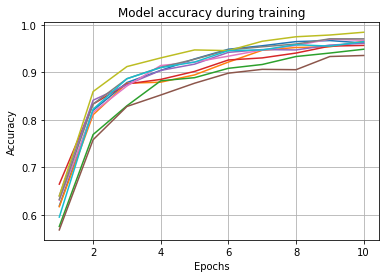

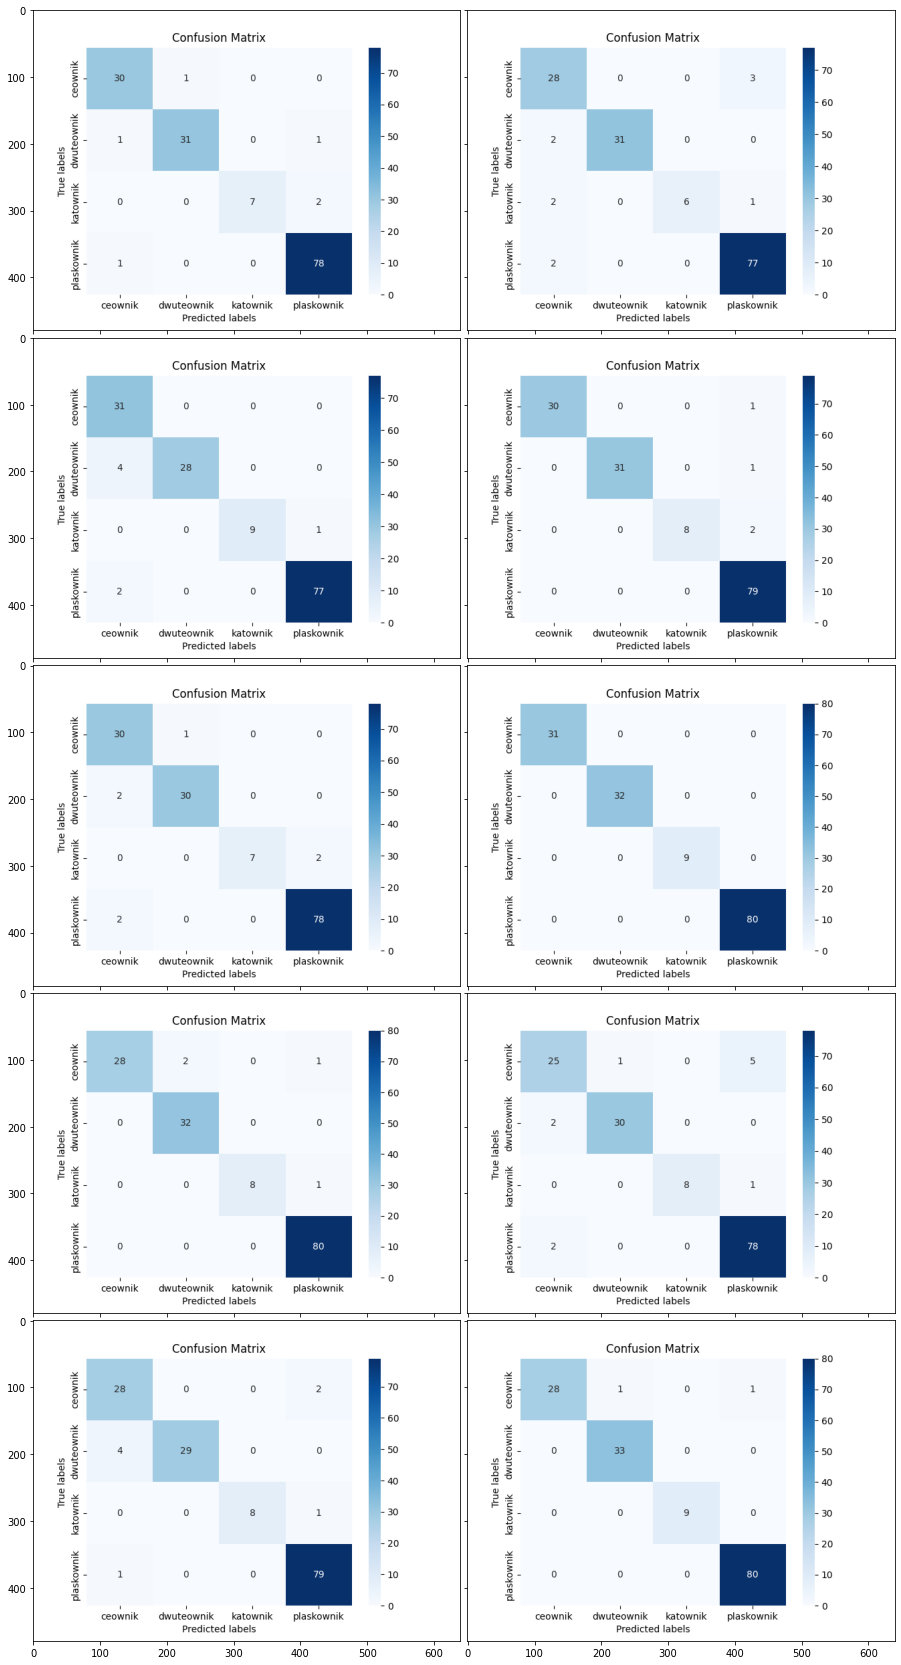

In [14]:
data = 'results/edge_data_xception'
compare_train_and_test_acc(data, edge_train_results, edge_test_results)
show_training_history(data)
show_confusion_matrix(data)

In [15]:
show_misclassified(data)

Fold: 1


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00054-view04.png,ceownik,dwuteownik,0.290292,0.528029,0.001874,0.179805
1,dwuteownik_00042-view02.png,dwuteownik,plaskownik,0.185906,0.008469,0.002733,0.802892
2,dwuteownik_00042-view04.png,dwuteownik,ceownik,0.565911,0.415927,0.000405,0.017757
3,katownik_00010-view02.png,katownik,plaskownik,0.016040,0.001477,0.011237,0.971246
4,katownik_00012-view04.png,katownik,plaskownik,0.107786,0.001293,0.441292,0.449629
5,plaskownik_00182-view03.png,plaskownik,ceownik,0.736534,0.004753,0.004701,0.254012


Fold: 2


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00053-view01.png,ceownik,plaskownik,0.153155,0.000079,0.072204,0.774563
1,ceownik_00053-view03.png,ceownik,plaskownik,0.174139,0.000150,0.088405,0.737306
2,ceownik_00054-view02.png,ceownik,plaskownik,0.029668,0.000176,0.000933,0.969224
3,dwuteownik_00020-view02.png,dwuteownik,ceownik,0.851133,0.148364,0.000081,0.000422
4,dwuteownik_00033-view01.png,dwuteownik,ceownik,0.694778,0.245159,0.002755,0.057308
5,katownik_00004-view01.png,katownik,ceownik,0.371239,0.000748,0.333833,0.294180
6,katownik_00004-view02.png,katownik,ceownik,0.444682,0.004331,0.241719,0.309267
7,katownik_00010-view01.png,katownik,plaskownik,0.429832,0.002860,0.093217,0.474091
8,plaskownik_00017-view03.png,plaskownik,ceownik,0.647519,0.007741,0.074314,0.270426
9,plaskownik_00182-view02.png,plaskownik,ceownik,0.632986,0.022732,0.010512,0.333770


Fold: 3


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,dwuteownik_00005-view03.png,dwuteownik,ceownik,0.748478,0.245041,0.006293,0.000188
1,dwuteownik_00024-view01.png,dwuteownik,ceownik,0.530165,0.414426,0.016869,0.038541
2,dwuteownik_00042-view03.png,dwuteownik,ceownik,0.659155,0.130073,0.015160,0.195612
3,dwuteownik_00083-view02.png,dwuteownik,ceownik,0.638103,0.356297,0.003417,0.002182
4,katownik_00010-view03.png,katownik,plaskownik,0.257957,0.045530,0.058764,0.637749
5,plaskownik_00017-view01.png,plaskownik,ceownik,0.700820,0.016467,0.129438,0.153275
6,plaskownik_00107-view03.png,plaskownik,ceownik,0.587899,0.007117,0.063572,0.341411


Fold: 4


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00054-view01.png,ceownik,plaskownik,0.255524,0.294215,0.008636,0.441625
1,dwuteownik_00024-view04.png,dwuteownik,plaskownik,0.090115,0.381242,0.004993,0.523651
2,katownik_00023-view01.png,katownik,plaskownik,0.001636,0.002990,0.007414,0.987959
3,katownik_00023-view03.png,katownik,plaskownik,0.021988,0.012881,0.035817,0.929313


Fold: 5


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00063-view03.png,ceownik,dwuteownik,0.400727,0.597477,0.000014,0.001782
1,dwuteownik_00024-view03.png,dwuteownik,ceownik,0.807166,0.169560,0.000464,0.022810
2,dwuteownik_00042-view01.png,dwuteownik,ceownik,0.826851,0.130017,0.000504,0.042627
3,katownik_00019-view03.png,katownik,plaskownik,0.000999,0.007648,0.362547,0.628806
4,katownik_00023-view04.png,katownik,plaskownik,0.009889,0.003374,0.044057,0.942681
5,plaskownik_00017-view04.png,plaskownik,ceownik,0.577532,0.113465,0.082761,0.226242
6,plaskownik_00089-view02.png,plaskownik,ceownik,0.849657,0.046530,0.001213,0.102600


Fold: 6


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik


Fold: 7


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00055-view04.png,ceownik,plaskownik,0.139134,0.013424,0.001332,0.846111
1,ceownik_00058-view01.png,ceownik,dwuteownik,0.016820,0.983127,0.000011,0.000043
2,ceownik_00058-view04.png,ceownik,dwuteownik,0.046480,0.953375,0.000021,0.000124
3,katownik_00012-view02.png,katownik,plaskownik,0.021598,0.000007,0.096252,0.882143


Fold: 8


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00001-view03.png,ceownik,plaskownik,0.448372,0.001960,0.017462,0.532207
1,ceownik_00001-view04.png,ceownik,plaskownik,0.049320,0.000593,0.028675,0.921413
2,ceownik_00017-view02.png,ceownik,plaskownik,0.432654,0.035458,0.089022,0.442866
3,ceownik_00035-view03.png,ceownik,plaskownik,0.334061,0.071011,0.000372,0.594556
4,ceownik_00067-view01.png,ceownik,plaskownik,0.402259,0.022836,0.003980,0.570926
5,ceownik_00075-view03.png,ceownik,dwuteownik,0.262129,0.719791,0.000115,0.017965
6,dwuteownik_00020-view01.png,dwuteownik,ceownik,0.933553,0.033918,0.000511,0.032018
7,dwuteownik_00083-view01.png,dwuteownik,ceownik,0.546648,0.446888,0.000056,0.006408
8,katownik_00010-view04.png,katownik,plaskownik,0.164801,0.007697,0.004845,0.822657
9,plaskownik_00089-view03.png,plaskownik,ceownik,0.788352,0.056503,0.001598,0.153547


Fold: 9


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00053-view02.png,ceownik,plaskownik,0.030645,0.000015,0.025847,0.943493
1,ceownik_00055-view01.png,ceownik,plaskownik,0.269949,0.084642,0.000086,0.645323
2,dwuteownik_00021-view02.png,dwuteownik,ceownik,0.498585,0.411984,0.040263,0.049168
3,dwuteownik_00022-view02.png,dwuteownik,ceownik,0.551379,0.419417,0.000230,0.028975
4,dwuteownik_00060-view01.png,dwuteownik,ceownik,0.969961,0.025722,0.000073,0.004244
5,dwuteownik_00060-view03.png,dwuteownik,ceownik,0.969961,0.025722,0.000073,0.004244
6,katownik_00023-view02.png,katownik,plaskownik,0.195167,0.001433,0.302413,0.500987
7,plaskownik_00110-view02.png,plaskownik,ceownik,0.491512,0.056099,0.000035,0.452354


Fold: 10


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00001-view02.png,ceownik,dwuteownik,0.356027,0.396736,0.003135,0.244102
1,ceownik_00054-view03.png,ceownik,plaskownik,0.157595,0.192862,0.002920,0.646623


## Krawędzie - VGG16 <a class="anchor" id="edge-vgg16"></a>

,0,1,2,3,4,5,6,7,8,9,10
,Fold: 1,Fold: 2,Fold: 3,Fold: 4,Fold: 5,Fold: 6,Fold: 7,Fold: 8,Fold: 9,Fold: 10,Mean
Training ACC,0.611111,0.853801,0.863304,0.868421,0.861842,0.782895,0.774854,0.660819,0.896199,0.771199,0.794444
Test Acc,0.605263,0.875,0.901316,0.901316,0.881579,0.828947,0.769737,0.671053,0.888158,0.901316,0.822368


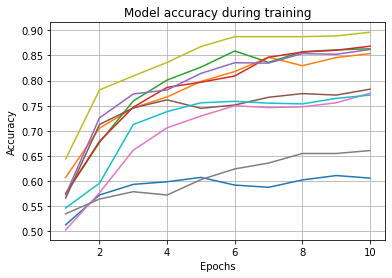

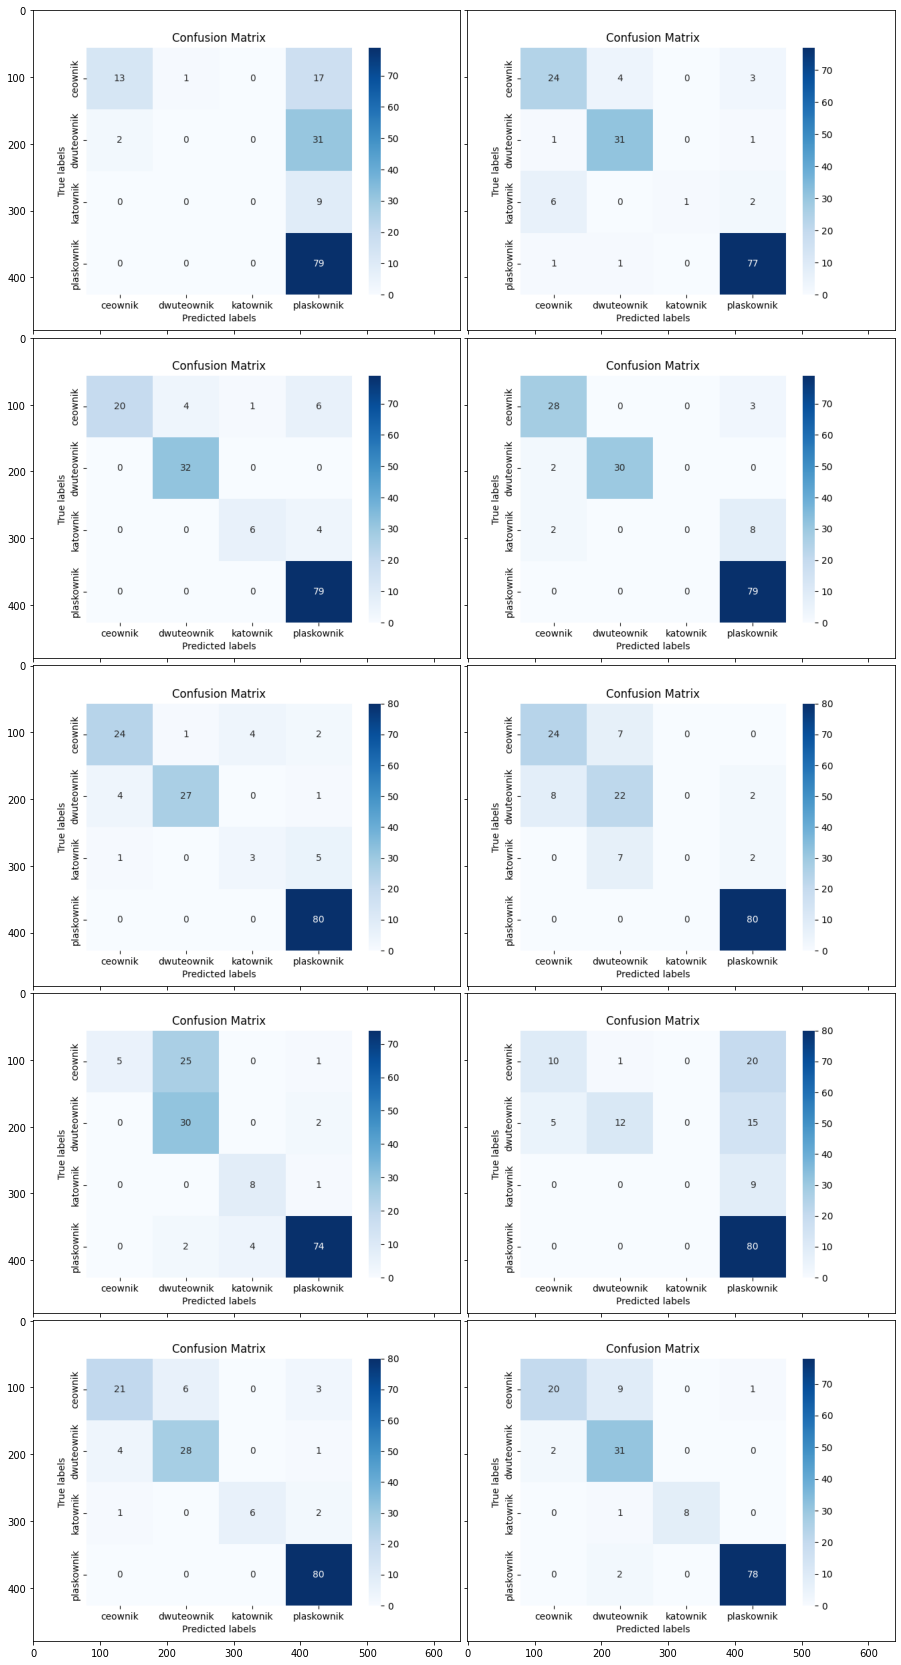

In [16]:
data = 'results/edge_data_vgg16'
compare_train_and_test_acc(data, edge_train_results, edge_test_results)
show_training_history(data)
show_confusion_matrix(data)

In [17]:
show_misclassified(data)

Fold: 1


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00005-view04.png,ceownik,plaskownik,0.217994,0.175343,0.193667,4.129961e-01
1,ceownik_00006-view02.png,ceownik,plaskownik,0.217663,0.173889,0.193371,4.150772e-01
2,ceownik_00015-view02.png,ceownik,plaskownik,0.228259,0.264664,0.202885,3.041924e-01
3,ceownik_00016-view01.png,ceownik,plaskownik,0.228259,0.264664,0.202885,3.041924e-01
4,ceownik_00020-view03.png,ceownik,plaskownik,0.228259,0.264664,0.202885,3.041924e-01
5,ceownik_00022-view03.png,ceownik,plaskownik,0.228259,0.264664,0.202885,3.041924e-01
6,ceownik_00038-view02.png,ceownik,plaskownik,0.228259,0.264664,0.202885,3.041924e-01
7,ceownik_00052-view03.png,ceownik,dwuteownik,0.287285,0.310056,0.209614,1.930450e-01
8,ceownik_00054-view04.png,ceownik,plaskownik,0.030778,0.001375,0.027238,9.406089e-01
9,ceownik_00058-view03.png,ceownik,plaskownik,0.228259,0.264664,0.202885,3.041924e-01


Fold: 2


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00021-view03.png,ceownik,dwuteownik,0.410720,0.586945,7.278295e-05,2.262505e-03
1,ceownik_00038-view01.png,ceownik,dwuteownik,0.423172,0.571932,2.382187e-04,4.657316e-03
2,ceownik_00053-view01.png,ceownik,plaskownik,0.088107,0.060492,1.610691e-01,6.903324e-01
3,ceownik_00053-view03.png,ceownik,plaskownik,0.097538,0.073544,1.941633e-01,6.347546e-01
4,ceownik_00054-view02.png,ceownik,plaskownik,0.125971,0.088185,1.765930e-01,6.092510e-01
5,ceownik_00069-view01.png,ceownik,dwuteownik,0.349259,0.650741,6.135750e-13,1.849064e-08
6,ceownik_00069-view03.png,ceownik,dwuteownik,0.375676,0.624310,4.260725e-09,1.336883e-05
7,dwuteownik_00020-view02.png,dwuteownik,ceownik,0.726360,0.124417,1.006440e-01,4.857968e-02
8,dwuteownik_00027-view01.png,dwuteownik,plaskownik,0.248741,0.273350,1.390054e-01,3.389040e-01
9,katownik_00002-view04.png,katownik,ceownik,0.261240,0.246744,2.467657e-01,2.452502e-01


Fold: 3


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00001-view01.png,ceownik,plaskownik,0.256547,0.237441,2.415848e-01,0.264426
1,ceownik_00015-view04.png,ceownik,plaskownik,0.256547,0.237441,2.415848e-01,0.264426
2,ceownik_00019-view03.png,ceownik,dwuteownik,0.277009,0.687864,4.413829e-03,0.030714
3,ceownik_00036-view01.png,ceownik,plaskownik,0.256547,0.237441,2.415848e-01,0.264426
4,ceownik_00048-view04.png,ceownik,dwuteownik,0.264777,0.523242,6.608398e-02,0.145898
5,ceownik_00051-view03.png,ceownik,katownik,0.071636,0.130560,7.014788e-01,0.096325
6,ceownik_00055-view03.png,ceownik,plaskownik,0.200408,0.163100,5.835314e-02,0.578139
7,ceownik_00059-view03.png,ceownik,plaskownik,0.256547,0.237441,2.415848e-01,0.264426
8,ceownik_00063-view01.png,ceownik,dwuteownik,0.016639,0.931203,1.818198e-10,0.052158
9,ceownik_00072-view04.png,ceownik,dwuteownik,0.209030,0.775464,1.272442e-03,0.014233


Fold: 4


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00005-view01.png,ceownik,plaskownik,0.147516,1.422599e-01,1.386331e-01,0.571591
1,ceownik_00054-view01.png,ceownik,plaskownik,0.022485,4.528473e-03,4.156995e-03,0.968829
2,ceownik_00068-view02.png,ceownik,plaskownik,0.120755,9.552787e-02,1.621876e-02,0.767499
3,dwuteownik_00020-view03.png,dwuteownik,ceownik,0.259581,2.492022e-01,2.472216e-01,0.243995
4,dwuteownik_00033-view04.png,dwuteownik,ceownik,0.259581,2.492022e-01,2.472216e-01,0.243995
5,katownik_00006-view03.png,katownik,plaskownik,0.233619,2.245482e-01,2.217081e-01,0.320125
6,katownik_00011-view02.png,katownik,plaskownik,0.038380,3.116611e-02,3.452063e-02,0.895933
7,katownik_00011-view03.png,katownik,plaskownik,0.000809,3.598983e-04,6.384751e-04,0.998193
8,katownik_00013-view01.png,katownik,plaskownik,0.022090,1.999542e-02,2.007961e-02,0.937835
9,katownik_00015-view04.png,katownik,plaskownik,0.027220,2.643260e-02,2.506484e-02,0.921282


Fold: 5


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00015-view03.png,ceownik,katownik,0.291836,0.007302,0.687317,0.013545
1,ceownik_00017-view03.png,ceownik,plaskownik,0.284471,0.037855,0.095192,0.582482
2,ceownik_00051-view02.png,ceownik,katownik,0.228337,0.001362,0.767242,0.003059
3,ceownik_00051-view04.png,ceownik,katownik,0.328311,0.118612,0.398877,0.154200
4,ceownik_00063-view03.png,ceownik,dwuteownik,0.317301,0.348113,0.146754,0.187832
5,ceownik_00076-view01.png,ceownik,katownik,0.414566,0.015663,0.552989,0.016782
6,ceownik_00076-view02.png,ceownik,plaskownik,0.257877,0.228030,0.250957,0.263136
7,dwuteownik_00024-view03.png,dwuteownik,ceownik,0.409769,0.122149,0.096892,0.371189
8,dwuteownik_00042-view01.png,dwuteownik,plaskownik,0.046751,0.024298,0.048883,0.880068
9,dwuteownik_00059-view02.png,dwuteownik,ceownik,0.701929,0.294765,0.001520,0.001787


Fold: 6


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00005-view02.png,ceownik,dwuteownik,0.243243,0.288773,0.236510,0.231474
1,ceownik_00006-view03.png,ceownik,dwuteownik,0.243243,0.288773,0.236510,0.231474
2,ceownik_00006-view04.png,ceownik,dwuteownik,0.243243,0.288773,0.236510,0.231474
3,ceownik_00016-view02.png,ceownik,dwuteownik,0.243243,0.288773,0.236510,0.231474
4,ceownik_00016-view03.png,ceownik,dwuteownik,0.243243,0.288773,0.236510,0.231474
5,ceownik_00036-view02.png,ceownik,dwuteownik,0.243243,0.288773,0.236510,0.231474
6,ceownik_00075-view01.png,ceownik,dwuteownik,0.243243,0.288773,0.236510,0.231474
7,dwuteownik_00001-view03.png,dwuteownik,ceownik,0.508348,0.404969,0.045975,0.040708
8,dwuteownik_00011-view04.png,dwuteownik,ceownik,0.395588,0.383209,0.114613,0.106590
9,dwuteownik_00012-view04.png,dwuteownik,ceownik,0.415254,0.390584,0.100960,0.093201


Fold: 7


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00002-view03.png,ceownik,dwuteownik,0.422810,5.760294e-01,0.000236,0.000925
1,ceownik_00003-view03.png,ceownik,dwuteownik,0.450341,5.440490e-01,0.001706,0.003904
2,ceownik_00010-view02.png,ceownik,dwuteownik,0.273981,2.748991e-01,0.217084,0.234036
3,ceownik_00010-view04.png,ceownik,dwuteownik,0.273981,2.748991e-01,0.217084,0.234036
4,ceownik_00011-view02.png,ceownik,dwuteownik,0.273981,2.748991e-01,0.217084,0.234036
5,ceownik_00011-view04.png,ceownik,dwuteownik,0.273981,2.748991e-01,0.217084,0.234036
6,ceownik_00013-view01.png,ceownik,dwuteownik,0.273981,2.748991e-01,0.217084,0.234036
7,ceownik_00019-view01.png,ceownik,dwuteownik,0.273981,2.748991e-01,0.217084,0.234036
8,ceownik_00027-view01.png,ceownik,dwuteownik,0.273981,2.748991e-01,0.217084,0.234036
9,ceownik_00037-view01.png,ceownik,dwuteownik,0.273981,2.748991e-01,0.217084,0.234036


Fold: 8


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00001-view03.png,ceownik,plaskownik,0.237547,0.265985,0.213517,0.282951
1,ceownik_00001-view04.png,ceownik,plaskownik,0.237547,0.265985,0.213517,0.282951
2,ceownik_00002-view04.png,ceownik,dwuteownik,0.297247,0.674511,0.021620,0.006622
3,ceownik_00004-view01.png,ceownik,plaskownik,0.237547,0.265985,0.213517,0.282951
4,ceownik_00005-view03.png,ceownik,plaskownik,0.224990,0.202424,0.082916,0.489670
5,ceownik_00015-view01.png,ceownik,plaskownik,0.237547,0.265985,0.213517,0.282951
6,ceownik_00017-view02.png,ceownik,plaskownik,0.230759,0.112034,0.253514,0.403693
7,ceownik_00035-view01.png,ceownik,plaskownik,0.237547,0.265985,0.213517,0.282951
8,ceownik_00035-view03.png,ceownik,plaskownik,0.237547,0.265985,0.213517,0.282951
9,ceownik_00037-view04.png,ceownik,plaskownik,0.237547,0.265985,0.213517,0.282951


Fold: 9


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00002-view01.png,ceownik,dwuteownik,0.234904,0.763739,6.269389e-04,7.305893e-04
1,ceownik_00003-view01.png,ceownik,dwuteownik,0.354096,0.632187,4.577128e-03,9.139440e-03
2,ceownik_00020-view04.png,ceownik,dwuteownik,0.380586,0.498954,5.922075e-02,6.123955e-02
3,ceownik_00022-view04.png,ceownik,dwuteownik,0.377065,0.465189,7.756600e-02,8.018075e-02
4,ceownik_00053-view02.png,ceownik,plaskownik,0.016337,0.000763,7.711434e-03,9.751881e-01
5,ceownik_00055-view01.png,ceownik,plaskownik,0.038274,0.001025,2.217270e-02,9.385290e-01
6,ceownik_00071-view02.png,ceownik,dwuteownik,0.337980,0.351229,1.529001e-01,1.578906e-01
7,ceownik_00074-view03.png,ceownik,dwuteownik,0.340964,0.640043,7.737822e-03,1.125505e-02
8,ceownik_00077-view01.png,ceownik,plaskownik,0.128168,0.151510,5.995084e-02,6.603711e-01
9,dwuteownik_00021-view02.png,dwuteownik,ceownik,0.503146,0.496854,3.696261e-31,4.617074e-15


Fold: 10


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00001-view02.png,ceownik,dwuteownik,0.238963,0.287293,0.220598,0.253146
1,ceownik_00004-view02.png,ceownik,dwuteownik,0.453618,0.488828,0.021771,0.035783
2,ceownik_00004-view04.png,ceownik,dwuteownik,0.462029,0.492744,0.016747,0.028480
3,ceownik_00006-view01.png,ceownik,dwuteownik,0.238963,0.287293,0.220598,0.253146
4,ceownik_00035-view04.png,ceownik,dwuteownik,0.238963,0.287293,0.220598,0.253146
5,ceownik_00036-view03.png,ceownik,dwuteownik,0.238963,0.287293,0.220598,0.253146
6,ceownik_00037-view03.png,ceownik,dwuteownik,0.238963,0.287293,0.220598,0.253146
7,ceownik_00054-view03.png,ceownik,dwuteownik,0.256459,0.306486,0.201377,0.235678
8,ceownik_00066-view02.png,ceownik,dwuteownik,0.238963,0.287293,0.220598,0.253146
9,ceownik_00075-view02.png,ceownik,plaskownik,0.000097,0.000644,0.011869,0.987390


## Krawędzie - ResNet50 <a class="anchor" id="edge-resnet50"></a>

,0,1,2,3,4,5,6,7,8,9,10
,Fold: 1,Fold: 2,Fold: 3,Fold: 4,Fold: 5,Fold: 6,Fold: 7,Fold: 8,Fold: 9,Fold: 10,Mean
Training ACC,0.531433,0.788743,0.894737,0.839181,0.793129,0.836257,0.932018,0.854532,0.848684,0.782895,0.810161
Test Acc,0.526316,0.848684,0.927632,0.914474,0.881579,0.901316,0.960526,0.881579,0.907895,0.828947,0.857895


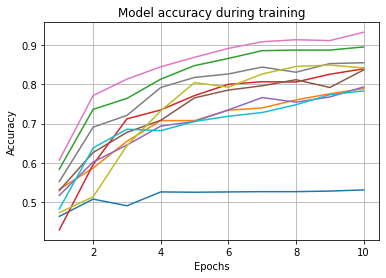

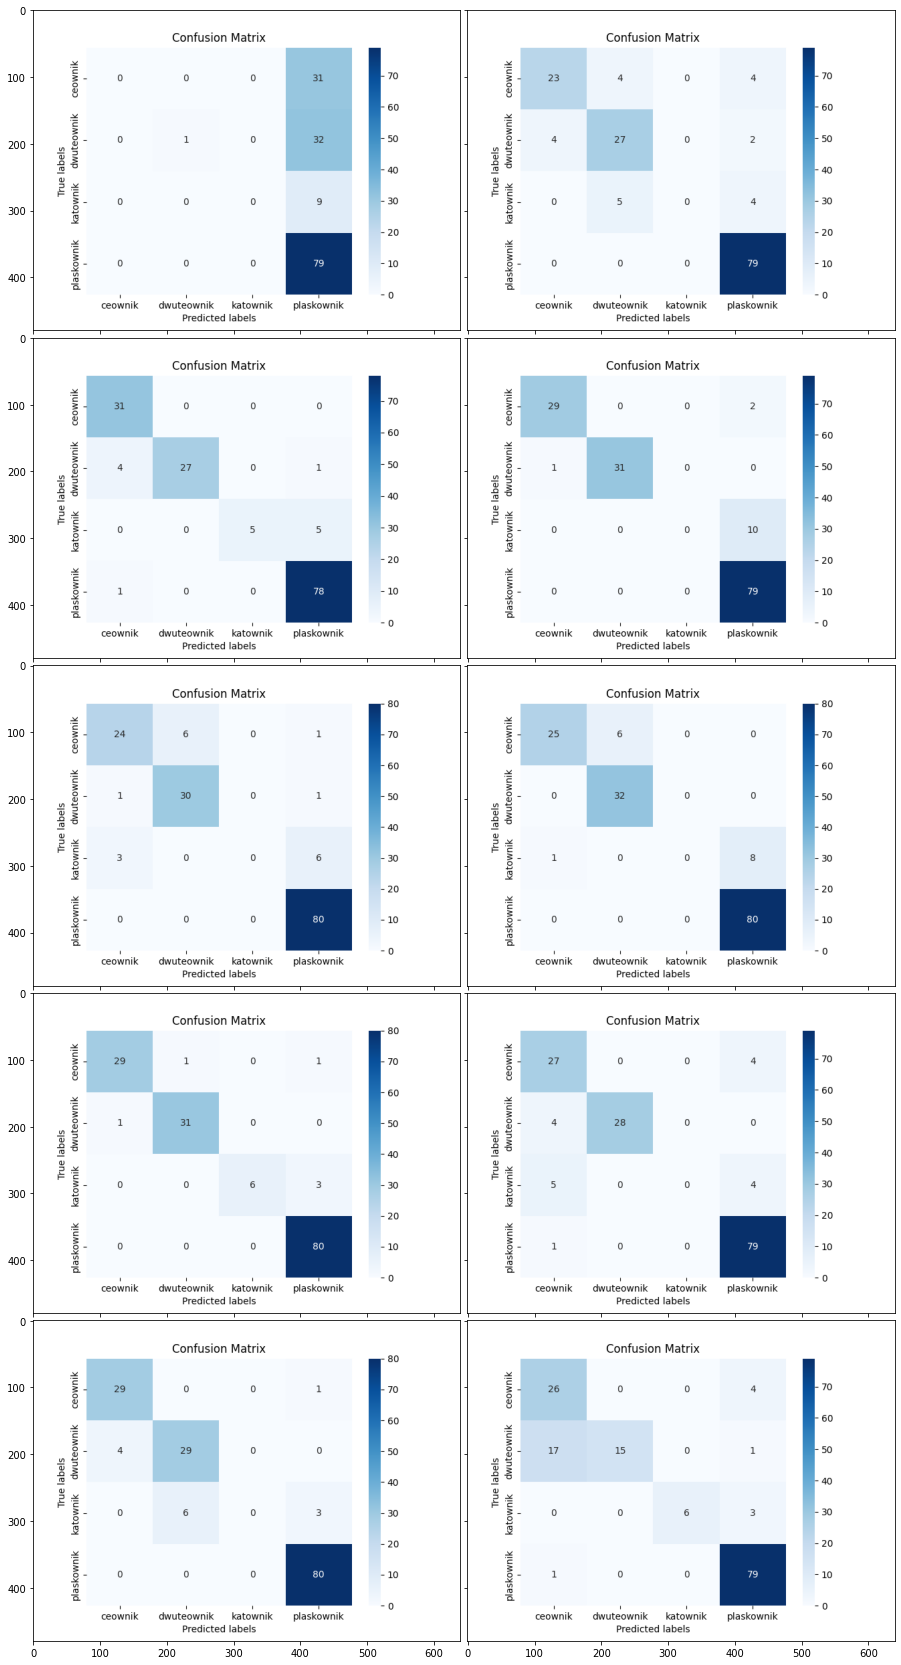

In [18]:
data = 'results/edge_data_resnet50_lr001'
compare_train_and_test_acc(data, edge_train_results, edge_test_results)
show_training_history(data)
show_confusion_matrix(data)

In [19]:
show_misclassified(data)

Fold: 1


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00005-view04.png,ceownik,plaskownik,0.252359,0.250951,0.239269,0.257421
1,ceownik_00006-view02.png,ceownik,plaskownik,0.181092,0.184083,0.120529,0.514296
2,ceownik_00008-view03.png,ceownik,plaskownik,0.252359,0.250951,0.239269,0.257421
3,ceownik_00009-view01.png,ceownik,plaskownik,0.252359,0.250951,0.239269,0.257421
4,ceownik_00009-view03.png,ceownik,plaskownik,0.252359,0.250951,0.239269,0.257421
...,...,...,...,...,...,...,...
67,katownik_00014-view02.png,katownik,plaskownik,0.252359,0.250951,0.239269,0.257421
68,katownik_00015-view01.png,katownik,plaskownik,0.151666,0.155289,0.089855,0.603190
69,katownik_00015-view02.png,katownik,plaskownik,0.108607,0.112445,0.053796,0.725152
70,katownik_00021-view01.png,katownik,plaskownik,0.252359,0.250951,0.239269,0.257421


Fold: 2


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00003-view02.png,ceownik,plaskownik,0.219240,0.241248,0.157859,0.381654
1,ceownik_00021-view03.png,ceownik,dwuteownik,0.248214,0.258394,0.245066,0.248326
2,ceownik_00038-view01.png,ceownik,dwuteownik,0.248214,0.258394,0.245066,0.248326
3,ceownik_00053-view01.png,ceownik,plaskownik,0.052896,0.052160,0.040683,0.854260
4,ceownik_00053-view03.png,ceownik,plaskownik,0.052176,0.051433,0.040071,0.856320
5,ceownik_00054-view02.png,ceownik,plaskownik,0.179874,0.183753,0.162814,0.473559
6,ceownik_00069-view01.png,ceownik,dwuteownik,0.248214,0.258394,0.245066,0.248326
7,ceownik_00069-view03.png,ceownik,dwuteownik,0.248214,0.258394,0.245066,0.248326
8,dwuteownik_00020-view02.png,dwuteownik,ceownik,0.728240,0.115908,0.022970,0.132883
9,dwuteownik_00022-view01.png,dwuteownik,ceownik,0.330805,0.246913,0.177457,0.244825


Fold: 3


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,dwuteownik_00024-view01.png,dwuteownik,ceownik,0.547811,0.147120,0.015082,0.289987
1,dwuteownik_00042-view03.png,dwuteownik,plaskownik,0.378341,0.076669,0.017699,0.527291
2,dwuteownik_00054-view01.png,dwuteownik,ceownik,0.601779,0.389769,0.000969,0.007484
3,dwuteownik_00083-view02.png,dwuteownik,ceownik,0.513123,0.481478,0.000811,0.004588
4,dwuteownik_00084-view02.png,dwuteownik,ceownik,0.734623,0.253919,0.000742,0.010715
5,katownik_00010-view03.png,katownik,plaskownik,0.331780,0.105906,0.098154,0.464160
6,katownik_00012-view01.png,katownik,plaskownik,0.347012,0.127441,0.125918,0.399629
7,katownik_00012-view03.png,katownik,plaskownik,0.343200,0.108336,0.101437,0.447027
8,katownik_00018-view04.png,katownik,plaskownik,0.112194,0.043821,0.055468,0.788517
9,katownik_00020-view01.png,katownik,plaskownik,0.096160,0.000279,0.314260,0.589302


Fold: 4


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00052-view04.png,ceownik,plaskownik,0.334289,0.311075,0.010248,0.344389
1,ceownik_00054-view01.png,ceownik,plaskownik,0.235493,0.034526,0.027155,0.702827
2,dwuteownik_00020-view03.png,dwuteownik,ceownik,0.482039,0.269052,0.021458,0.227451
3,katownik_00006-view03.png,katownik,plaskownik,0.046207,0.026093,0.437784,0.489916
4,katownik_00011-view02.png,katownik,plaskownik,0.010486,0.004466,0.457734,0.527314
5,katownik_00011-view03.png,katownik,plaskownik,0.005069,0.001608,0.441535,0.551788
6,katownik_00013-view01.png,katownik,plaskownik,0.009852,0.003704,0.446412,0.540032
7,katownik_00015-view04.png,katownik,plaskownik,0.004957,0.005768,0.336411,0.652864
8,katownik_00018-view02.png,katownik,plaskownik,0.011743,0.008687,0.394301,0.585269
9,katownik_00020-view04.png,katownik,plaskownik,0.033078,0.017061,0.444137,0.505724


Fold: 5


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00017-view03.png,ceownik,dwuteownik,0.354304,0.401049,0.125391,0.119256
1,ceownik_00018-view01.png,ceownik,dwuteownik,0.308197,0.657458,0.020593,0.013752
2,ceownik_00018-view04.png,ceownik,dwuteownik,0.323904,0.652336,0.013908,0.009852
3,ceownik_00048-view01.png,ceownik,dwuteownik,0.357824,0.630735,0.006333,0.005109
4,ceownik_00072-view03.png,ceownik,dwuteownik,0.322012,0.628204,0.029291,0.020493
5,ceownik_00076-view01.png,ceownik,plaskownik,0.281485,0.192605,0.229903,0.296007
6,ceownik_00076-view02.png,ceownik,dwuteownik,0.325050,0.620541,0.031864,0.022546
7,dwuteownik_00024-view03.png,dwuteownik,ceownik,0.456110,0.144057,0.061785,0.338047
8,dwuteownik_00042-view01.png,dwuteownik,plaskownik,0.164071,0.021005,0.033227,0.781698
9,katownik_00001-view04.png,katownik,ceownik,0.253400,0.248102,0.249013,0.249485


Fold: 6


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00002-view02.png,ceownik,dwuteownik,0.456036,0.496629,0.015944,0.031391
1,ceownik_00003-view04.png,ceownik,dwuteownik,0.444283,0.524017,0.009517,0.022183
2,ceownik_00005-view02.png,ceownik,dwuteownik,0.275658,0.656493,0.035077,0.032772
3,ceownik_00006-view03.png,ceownik,dwuteownik,0.246153,0.716942,0.019238,0.017668
4,ceownik_00006-view04.png,ceownik,dwuteownik,0.294684,0.597517,0.055360,0.052439
5,ceownik_00018-view03.png,ceownik,dwuteownik,0.452180,0.533012,0.006591,0.008217
6,katownik_00001-view02.png,katownik,plaskownik,0.247837,0.251074,0.249915,0.251173
7,katownik_00001-view03.png,katownik,plaskownik,0.247837,0.251074,0.249915,0.251173
8,katownik_00002-view02.png,katownik,plaskownik,0.247837,0.251074,0.249915,0.251173
9,katownik_00002-view03.png,katownik,plaskownik,0.247837,0.251074,0.249915,0.251173


Fold: 7


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00055-view04.png,ceownik,plaskownik,0.452483,0.084251,0.004355,4.589108e-01
1,ceownik_00058-view04.png,ceownik,dwuteownik,0.360312,0.639685,0.000002,1.604511e-07
2,dwuteownik_00021-view01.png,dwuteownik,ceownik,0.530646,0.469332,0.000019,1.651303e-06
3,katownik_00012-view02.png,katownik,plaskownik,0.022042,0.000219,0.016358,9.613820e-01
4,katownik_00016-view04.png,katownik,plaskownik,0.188783,0.004235,0.346531,4.604514e-01
5,katownik_00018-view01.png,katownik,plaskownik,0.134881,0.000594,0.214146,6.503783e-01


Fold: 8


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00001-view03.png,ceownik,plaskownik,0.372687,0.118160,0.020400,0.488753
1,ceownik_00001-view04.png,ceownik,plaskownik,0.156434,0.066450,0.062815,0.714301
2,ceownik_00053-view04.png,ceownik,plaskownik,0.042165,0.015614,0.143732,0.798490
3,ceownik_00075-view03.png,ceownik,plaskownik,0.175139,0.050725,0.000853,0.773284
4,dwuteownik_00020-view01.png,dwuteownik,ceownik,0.735520,0.189273,0.003704,0.071502
5,dwuteownik_00069-view03.png,dwuteownik,ceownik,0.557406,0.403359,0.001624,0.037612
6,dwuteownik_00083-view01.png,dwuteownik,ceownik,0.847117,0.128094,0.000281,0.024507
7,dwuteownik_00083-view03.png,dwuteownik,ceownik,0.870556,0.086115,0.000806,0.042523
8,katownik_00003-view01.png,katownik,ceownik,0.251567,0.247986,0.250727,0.249720
9,katownik_00005-view04.png,katownik,ceownik,0.251567,0.247986,0.250727,0.249720


Fold: 9


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00053-view02.png,ceownik,plaskownik,0.238237,0.011371,0.208246,0.542146
1,dwuteownik_00021-view02.png,dwuteownik,ceownik,0.636643,0.076778,0.082781,0.203798
2,dwuteownik_00022-view04.png,dwuteownik,ceownik,0.531299,0.252825,0.012671,0.203205
3,dwuteownik_00060-view01.png,dwuteownik,ceownik,0.704231,0.081477,0.031400,0.182892
4,dwuteownik_00060-view03.png,dwuteownik,ceownik,0.704231,0.081477,0.031400,0.182892
5,katownik_00003-view04.png,katownik,plaskownik,0.000690,0.000047,0.493372,0.505890
6,katownik_00005-view03.png,katownik,dwuteownik,0.250543,0.253606,0.249288,0.246563
7,katownik_00007-view03.png,katownik,dwuteownik,0.250543,0.253606,0.249288,0.246563
8,katownik_00009-view02.png,katownik,dwuteownik,0.250543,0.253606,0.249288,0.246563
9,katownik_00009-view04.png,katownik,dwuteownik,0.250543,0.253606,0.249288,0.246563


Fold: 10


,fname,true_label,predicted_label,ceownik,dwuteownik,katownik,plaskownik
0,ceownik_00001-view02.png,ceownik,plaskownik,0.097125,0.121132,0.067502,0.714242
1,ceownik_00054-view03.png,ceownik,plaskownik,0.063802,0.082012,0.066262,0.787924
2,ceownik_00069-view04.png,ceownik,plaskownik,0.141137,0.180201,0.158000,0.520662
3,ceownik_00075-view02.png,ceownik,plaskownik,0.132501,0.092030,0.019492,0.755976
4,dwuteownik_00007-view01.png,dwuteownik,ceownik,0.370662,0.276628,0.125827,0.226882
5,dwuteownik_00008-view01.png,dwuteownik,ceownik,0.370573,0.276621,0.125896,0.226910
6,dwuteownik_00019-view04.png,dwuteownik,ceownik,0.345937,0.274109,0.145987,0.233967
7,dwuteownik_00023-view03.png,dwuteownik,ceownik,0.424563,0.277669,0.089204,0.208564
8,dwuteownik_00027-view03.png,dwuteownik,ceownik,0.357977,0.275502,0.135886,0.230634
9,dwuteownik_00027-view04.png,dwuteownik,ceownik,0.457845,0.275443,0.071014,0.195697


# Porównanie architektur <a class="anchor" id="comp-a"></a>

## Porównanie architektur z użyciem czarnego tła <a class="anchor" id="comp-black"></a>

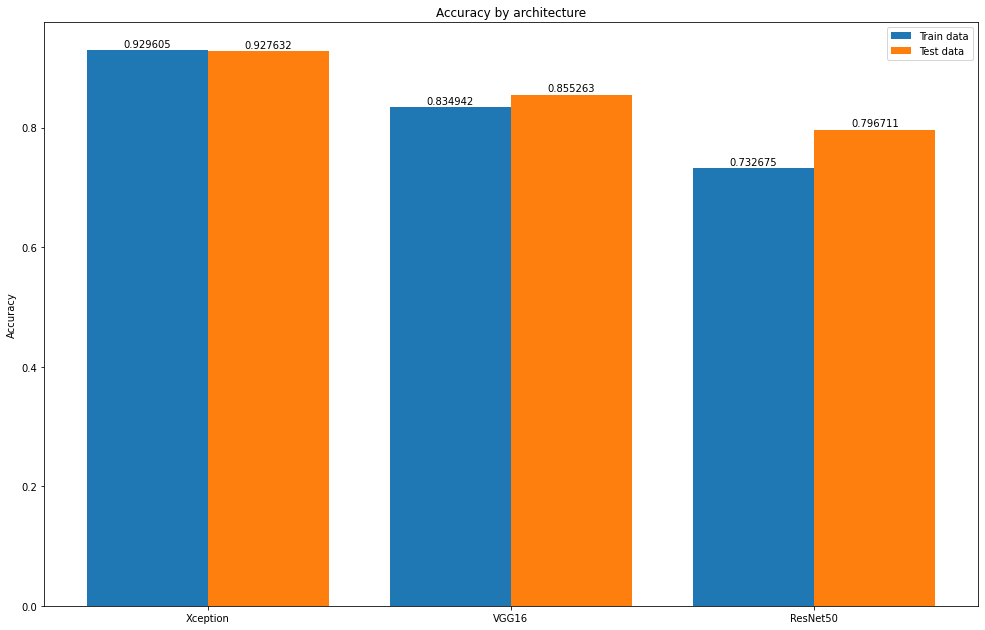

In [20]:
compare_architecture(black_train_results, black_test_results)

## Porównanie architektur z użyciem białego tła <a class="anchor" id="comp-white"></a>

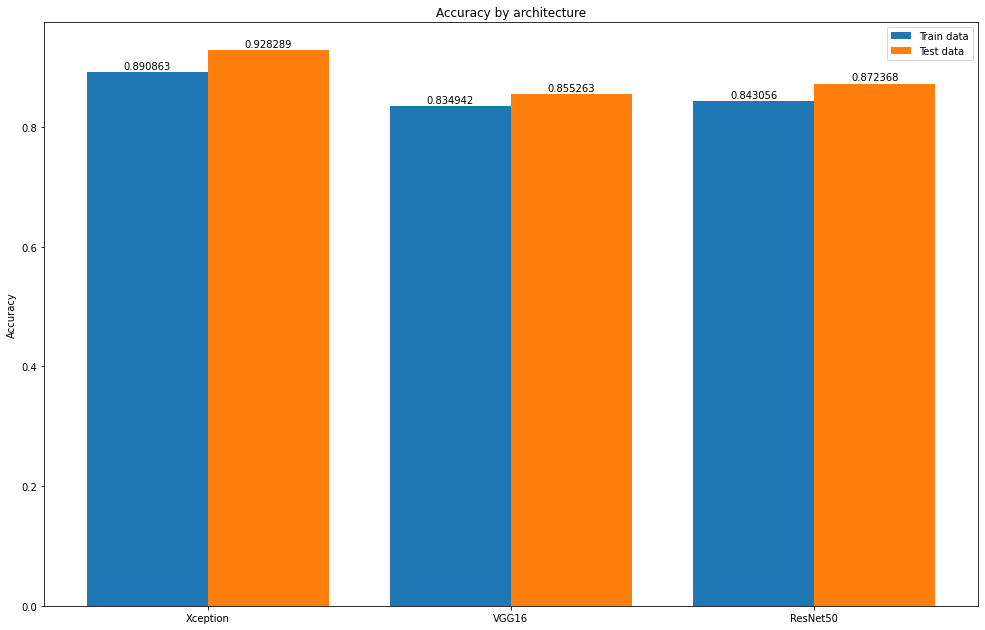

In [21]:
compare_architecture(white_train_results, white_test_results)

## Porównanie architektur z użyciem krawędzi <a class="anchor" id="comp-edge"></a>

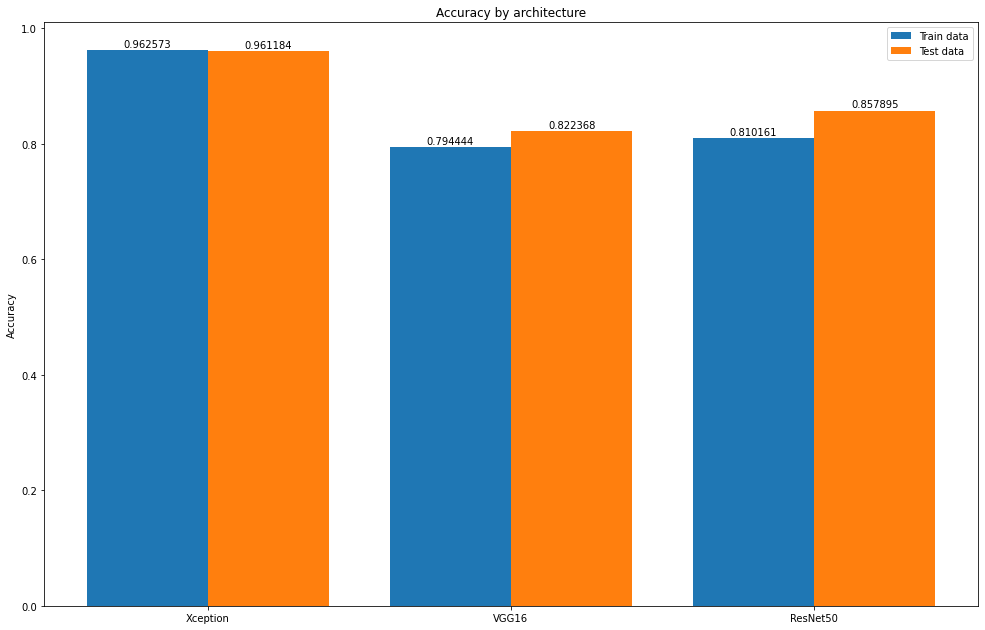

In [22]:
compare_architecture(edge_train_results, edge_test_results)

# Porównanie zbiorów uczącyc <a class="anchor" id="comp-z"></a>

## Porównanie zbiorów - Xception <a class="anchor" id="comp-xception"></a>

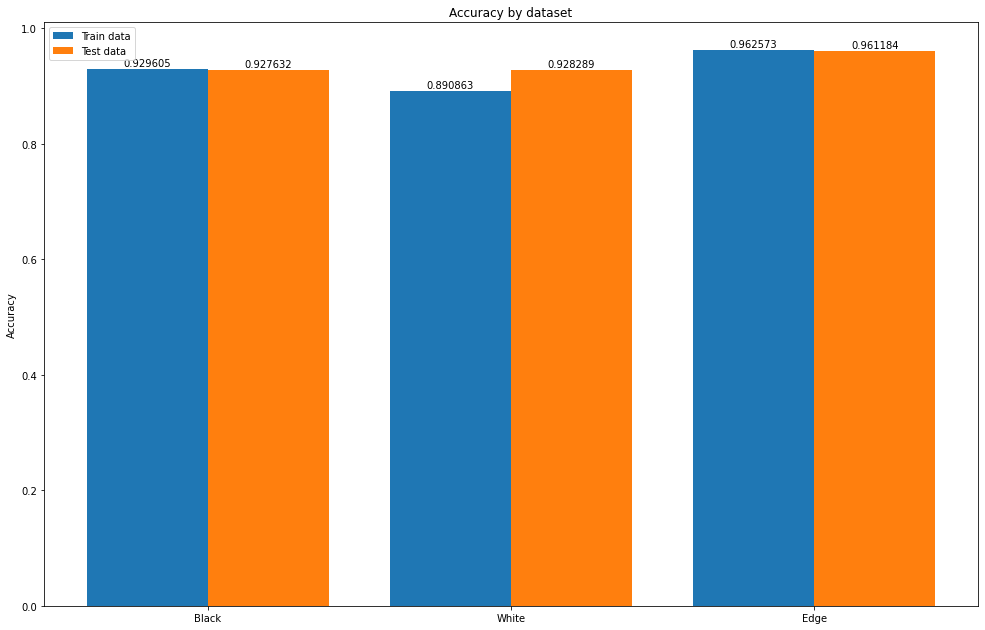

In [23]:
train_acc = [black_train_results[0], white_train_results[0], edge_train_results[0]]
test_acc = [black_test_results[0], white_test_results[0], edge_test_results[0]]
compare_dataset(train_acc, test_acc)

## Porównanie zbiorów - VGG16 <a class="anchor" id="comp-vgg16"></a>

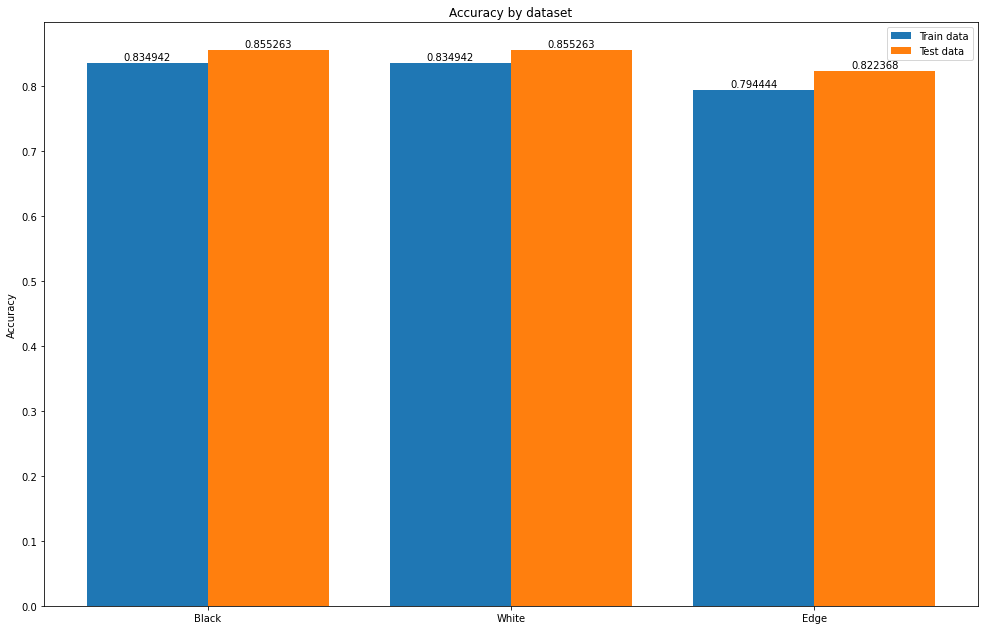

In [24]:
train_acc = [black_train_results[1], white_train_results[1], edge_train_results[1]]
test_acc = [black_test_results[1], white_test_results[1], edge_test_results[1]]
compare_dataset(train_acc, test_acc)

## Porównanie zbiorów - ResNet50 <a class="anchor" id="comp-resnet50"></a>

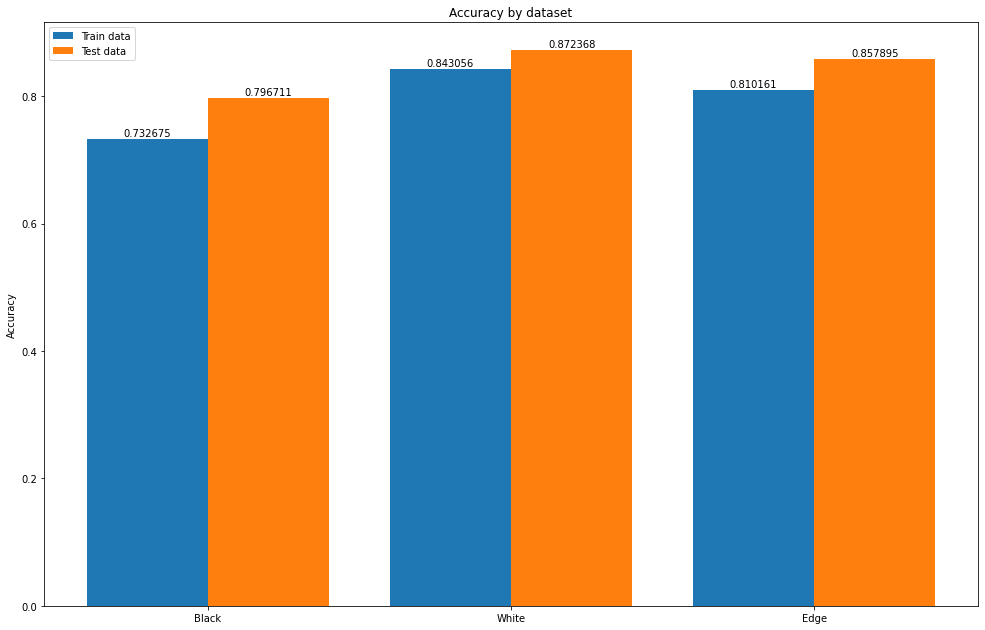

In [25]:
train_acc = [black_train_results[2], white_train_results[2], edge_train_results[2]]
test_acc = [black_test_results[2], white_test_results[2], edge_test_results[2]]
compare_dataset(train_acc, test_acc)